In [1]:
# David Data - Dataset processing (into multidimensional bins)

# Processing whole dataset as one, and seasons separately
# Also processing year by year

# Data on normal lat-lon coords OR lat-LT coords, OR alt-lat-LT (but calculates no of occs rather than occ freq since no altitude data where Es not detected)

# Uses bins as defined in my previous COSMIC data processing
# OR
# Can turn on fivedegbins switch to use 5x5 deg lat lon bins

# Original data has already filtered for Es. Where Es are detected, hmEs and s4s exist, else they are NaNs. So my processing says where not NaN, count as Es 


In [156]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import datetime as dt
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
#jet = mcm.get_cmap('jet')
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import sys
import os
import psutil
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
from tqdm import tqdm
import dask.array as da
import dask.dataframe as dd
import dask
%matplotlib inline 
import matplotlib.gridspec as gridspec
#import line_profiler
#%load_ext line_profiler

/tmp/ipykernel_805475/2282274303.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


# Open WACCM dataset (& 5' bins switch)

In [157]:
fivedegbins = 1

In [158]:
################################################################################
# Open WACCM dataset to define bins
################################################################################

# arrays sliced between chosen range (~90-130km) indices 42-60, 19 levels

file1name='Nc_Files/SpE_Output/Wuhu_IonTr_run_SpE_Output_Dec-Feb.nc' 
wds = xr.open_dataset(file1name)

wds_lat = wds['lat']
wds_lon = wds['lon']

lev_sl = wds['lev_sl']
Zavg_sl = wds.variables['Zavg_sl'] 
 
altavg_sl = wds['altavg_sl']
# altavg_sl.values # array([131.1492157 , 126.73989868, 122.75083923, 119.16303253,
#        115.95503998, 113.10031128, 110.56510162, 108.3082428 ,
#        106.28289795, 104.44081879, 102.7361145 , 101.12830353,
#         99.58457184,  98.0800705 ,  96.59645081,  95.12115479,
#         93.64645386,  92.16801453,  90.6837616 ])


print('    Array lev = ' + str("%.1e" % lev_sl[-1] ) + 'hPa : ' + str("%.1e" % lev_sl[0] ) + 'hPa'
           + ' (Z3 approx ' + str("%.0f" % Zavg_sl[-1]) + '-' + str("%.0f" % Zavg_sl[0] ) + 'km' + ',' 
           + ' Alt approx ' + str("%.0f" % altavg_sl[-1]) + '-' + str("%.0f" % altavg_sl[0] ) + 'km' + ')' )

    Array lev = 1.3e-03hPa : 1.5e-05hPa (Z3 approx 89-129km, Alt approx 91-131km)


# Defining Lat Bins

In [159]:
################################################################################
# Lat bins
################################################################################

lat_bin_edges = wds_lat.values
lat_bin_midpoints = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2
#lat_bin_widths = np.diff(lat_bin_edges)
#lat_average_bin_width = np.mean(lat_bin_widths)
lat_num_bins = len(lat_bin_midpoints)


# # ##Print the results
# print("Lat Bin Edges (Lower and Upper):")
# for i in range(len(lat_bin_edges) - 1):
#     print(f"Bin {i + 1}: [{lat_bin_edges[i]}, {lat_bin_edges[i + 1]}]")

# print("\nLat Bin Midpoints:")
# for i in range(len(lat_bin_midpoints)):
#     print(f"Bin {i + 1} Midpoint: {lat_bin_midpoints[i]}")

# print("\nLat Bin Widths:", lat_bin_widths)
# print(f"Lat Average Bin Width: {lat_average_bin_width:.6f} degrees")
# print(f"Lat Number of Bins: {lat_num_bins}")


# # Lat Average Bin Width: 1.894737 degrees
# # Lat Number of Bins: 95

# Defining Lon Bins

In [160]:
# ################################################################################
# # Lon bins -180 -> 180
# ################################################################################

# Updated value for a range of -180 to +180 degrees
lon_upper_edge_last_bin = 180.0
lon_bin_edges = np.append(np.arange(-180.0, 180.0, 2.5), lon_upper_edge_last_bin)
lon_bin_midpoints = (lon_bin_edges[:-1] + lon_bin_edges[1:]) / 2

# Other calculations (width, number of bins, etc.) remain the same
lon_bin_widths = np.diff(lon_bin_edges)
lon_average_bin_width = np.mean(lon_bin_widths)
lon_num_bins = len(lon_bin_midpoints)

# # Print the results
# print("Lon Bin Edges (Lower and Upper):")
# for i in range(len(lon_bin_edges) - 1):
#     print(f"Bin {i + 1}: [{lon_bin_edges[i]}, {lon_bin_edges[i + 1]}]")

# print("\nLon Bin Midpoints:")
# for i in range(len(lon_bin_midpoints)):
#     print(f"Lon Bin {i + 1} Midpoint: {lon_bin_midpoints[i]}")

# print("\nLon Bin Widths:", lon_bin_widths)
# print(f"Average Lon Bin Width: {lon_average_bin_width:.8f} degrees")
# print(f"Number of Lon Bins: {lon_num_bins}")

# Defining 5 Degree Bins 

In [161]:
################################################################################
# 5 deg Lat bins
################################################################################

if fivedegbins == 1:
    lat_values = np.arange(-90, 95, 5)
    lat_bin_edges = lat_values
    lat_bin_midpoints = (lat_bin_edges[:-1] + lat_bin_edges[1:]) / 2
    lat_num_bins = len(lat_bin_midpoints)

    lon_bin_edges = np.arange(-180, 185, 5)
    lon_bin_midpoints = (lon_bin_edges[:-1] + lon_bin_edges[1:]) / 2
    lon_num_bins = len(lon_bin_midpoints) #72

# Defining Altitude Bins

In [162]:
################################################################################
# Zavg_70150 bins - Note first bin is at top
# Bins between 70 and 150 km
################################################################################


wdss = xr.open_dataset('Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0002-01-01-00000.nc')
geopH = geopH = wdss['Z3'] / 1000
Zavg = geopH.mean(('time','lat', 'lon'))

index_70 = np.abs(Zavg - 70).argmin()
index_150 = np.abs(Zavg - 150).argmin()

Zavg_70150 = Zavg[int(index_150.item()):int(index_70.item())+1]
#Zavg_70150


Zavg_70150_bin_widths = np.diff(Zavg_70150.values)
Zavg_70150_bin_edges = [Zavg_70150[0] - Zavg_70150_bin_widths[0] / 2] + [Zavg_70150[i] + Zavg_70150_bin_widths[i] / 2 for i in range(len(Zavg_70150_bin_widths))] + [Zavg_70150[-1] + Zavg_70150_bin_widths[-1] / 2]
Zavg_70150_bin_midpoints = [(Zavg_70150_bin_edges[i] + Zavg_70150_bin_edges[i + 1]) / 2 for i in range(len(Zavg_70150_bin_edges) - 1)]
Zavg_70150_num_bins = len(Zavg_70150_bin_midpoints)


# # Print the bin edges and midpoints
# print("Zavg_70150 Bin Edges (Lower and Upper):")
# for i in range(len(Zavg_70150_bin_edges) - 1):
#     print(f"Bin {i + 1}: [{Zavg_70150_bin_edges[i].values}, {Zavg_70150_bin_edges[i + 1].values}]")

# print("\nZavg_70150 Bin Midpoints:")
# for i in range(len(Zavg_70150_bin_midpoints)):
#     print(f"Bin {i + 1} Midpoint: {Zavg_70150_bin_midpoints[i].values}")

# # Print the bin widths
# print("\nZavg_70150 Bin Widths:")
# for i in range(len(Zavg_70150_bin_widths)):
#     print(f"Bin {i + 1} Width: {Zavg_70150_bin_widths[i]}")

# print(f"Number of Bins: {Zavg_70150_num_bins}")

# Defining LT Bins

In [163]:
LT_bin_edges = np.linspace(0, 24, 49)
LT_bin_edges[-1] = 24.0

# Calculate bin midpoints
LT_bin_midpoints = (LT_bin_edges[:-1] + LT_bin_edges[1:]) / 2

# Calculate the number of bins
LT_num_bins = len(LT_bin_edges) - 1

# Calculate bin widths
LT_bin_widths = np.diff(LT_bin_edges)

# Calculate the average bin width
average_bin_width = np.sum(LT_bin_widths) / LT_num_bins


# ##Print the results
# print("LT Bin Edges (Lower and Upper):")
# for i in range(len(LT_bin_edges) - 1):
#     print(f"Bin {i + 1}: [{LT_bin_edges[i]}, {LT_bin_edges[i + 1]}]")

# print("\nLT Bin Midpoints:")
# for i in range(len(LT_bin_midpoints)):
#     print(f"Bin {i + 1} Midpoint: {LT_bin_midpoints[i]}")

# print("\nNumber of LT Bins:")
# print(LT_num_bins)

# # Print the average bin width
# print("Average LT Bin Width:", average_bin_width)

# Load magnetic gridlines for plot

In [164]:
#Define magnetic latitude lines

filename='Nc_Files/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h0.0001-06.nc' 
ds = xr.open_dataset(filename)
ALATM = ds.variables['ALATM'] #Magnetic latitude at each geographic coordinate
ALat = ds.variables['lat']
ALon = ds.variables['lon']

# COSMIC Data Loading (Lat-Lon, 2006-2019)

In [165]:
cosmicnc = 'Nc_Files/s4max_files/COSMIC1_for_Leeds.h5'
cds = xr.open_dataset(cosmicnc)

Jdate = cds['Julian_date']
lat = cds['Latitude']
lon = cds['Longitude']
hmEs = cds['hmEs']
s4s = cds['s4s']

phony_dim_0 = cds['phony_dim_0']

s4s.shape #(7657632,)

(7657632,)

In [166]:
# Convert julian date to datetime
#======================================

datetimes = pd.to_datetime(Jdate.values, unit='D', origin='julian')

# datetime[0]  #Timestamp('2006-04-30 05:56:08.043825024')
# datetime[-1]  #Timestamp('2019-12-10 12:39:50.466977536')
datetimes.shape #(7657632,)

(7657632,)

In [167]:
# Print values of variables between a chosen range for info
#======================================

for index in range(1, 50):
    lat_value = lat[index].values
    lon_value = lon[index].values
    hmEs_value = hmEs[index].values
    s4s_value = s4s[index].values
    datetime_value = datetimes[index]
    Jdate_value = Jdate[index].values

    #print(f"Index {index}: dt = {datetime_value}, lat = {lat_value}, lon = {lon_value}, hmEs = {hmEs_value}, s4s = {s4s_value}")

In [168]:
# Sort into consecutive time order
#======================================


cds_sorted = cds.sortby('Julian_date')

# Extract sorted variables
sorted_datetimes = pd.to_datetime(cds_sorted['Julian_date'].values, unit='D', origin='julian')
sorted_lat = cds_sorted['Latitude'].values
sorted_lon = cds_sorted['Longitude'].values
sorted_hmEs = cds_sorted['hmEs'].values
sorted_s4s = cds_sorted['s4s'].values


# # Print a subset of sorted variables for indices 0 to 99
# for i in range(50):
#     print(f"Ind {i}: dt = {sorted_datetimes[i]}, lat = {sorted_lat[i]}, lon = {sorted_lon[i]}, hmEs = {sorted_hmEs[i]}, s4s = {sorted_s4s[i]}")

In [169]:
# Identify indices where date/time = nan
# Remove occultations where date/time = nan
#======================================

ind_to_remove = []

for index in range(len(sorted_datetimes)):
    if pd.isna(sorted_datetimes[index]):
        lat_value = sorted_lat[index]
        lon_value = sorted_lon[index]
        hmEs_value = sorted_hmEs[index]
        s4s_value = sorted_s4s[index]
        
        ind_to_remove.append(index)
        
        #print(f"Index {index}: lat = {lat_value}, lon = {lon_value}, hmEs = {hmEs_value}, s4s = {s4s_value}")

## Create a new DataFrame without the specified indices
filtered_df = pd.DataFrame({'datetime': sorted_datetimes, 'lat': sorted_lat, 'lon': sorted_lon, 'hmEs': sorted_hmEs, 's4s': sorted_s4s})

# Use the separate variable ind_to_remove to remove indices
filtered_df = filtered_df[~filtered_df.index.isin(ind_to_remove)]

# Print the resulting DataFrame
print(filtered_df)

                             datetime        lat         lon  hmEs  s4s
0       2006-04-30 05:56:08.043825024  51.270003   95.375549   NaN  NaN
1       2006-04-30 05:56:36.604321920  64.094526  123.877350   NaN  NaN
2       2006-04-30 05:56:53.465184000  21.259120  137.635163   NaN  NaN
3       2006-04-30 06:01:05.802982400  45.922146  119.382021   NaN  NaN
4       2006-04-30 06:03:08.944861312  35.060482  143.047881   NaN  NaN
...                               ...        ...         ...   ...  ...
7657516 2019-12-10 11:30:26.465624576  23.987218   78.103606   NaN  NaN
7657517 2019-12-10 11:39:52.366115840 -11.536251   79.228695   NaN  NaN
7657518 2019-12-10 11:48:34.206978560 -49.524546   64.884119   NaN  NaN
7657519 2019-12-10 12:39:28.187154944  49.982191 -112.757110   NaN  NaN
7657520 2019-12-10 12:39:50.466977536  43.841069  -96.843928   NaN  NaN

[7657521 rows x 5 columns]


In [170]:
# Load sliced data and re index so consecutive numbers
#======================================

fdatetimes = filtered_df['datetime']
flat = filtered_df['lat']
flon = filtered_df['lon']
fhmEs = filtered_df['hmEs']
fs4s = filtered_df['s4s']

# Reset indices for consistency
fdatetimes.reset_index(drop=True, inplace=True)
flat.reset_index(drop=True, inplace=True)
flon.reset_index(drop=True, inplace=True)
fs4s.reset_index(drop=True, inplace=True)

# Local Time Conversion

In [171]:
# # Calculate time intervals between data
# #======================================

# fdatetimes = pd.to_datetime(fdatetimes)

# # Convert DatetimeIndex directly to a list of datetime objects
# datetime_objects = fdatetimes.tolist()

# # Calculate time intervals for the whole dataset
# time_intervals = [(datetime_objects[i] - datetime_objects[i-1]).total_seconds() for i in range(1, len(datetime_objects))]

# # Define the range to print intervals (inclusive)
# start_index = 0  # Change this to your desired start index
# end_index = 49   # Change this to your desired end index

# # Print time intervals within the specified range
# for i in range(start_index, min(end_index, len(time_intervals))):
#     print(f"Interval between Index {i+1} and Index {i+2}: {time_intervals[i]} seconds")

In [172]:
# # Calculate lon intervals between data
# #======================================


# lon_diffs = flon.diff().fillna(0)  # Take the difference and fill missing values with 0

# # Define the range to print intervals (inclusive)
# start_index = 0  # Change this to your desired start index
# end_index = 49   # Change this to your desired end index

# # Print longitude differences within the specified range
# for i in range(start_index, min(end_index, len(lon_diffs))):
#     print(f"Difference between Index {i+1} and Index {i+2}: {lon_diffs[i]}")

In [173]:
# Calculate Local Time
#======================================

local_times = []
adjusted_lons = []  # Store adjusted longitudes for verification

for timestamp, lon in zip(fdatetimes, flon):
    # Find the reference time as the UT timestamp
    reference_time = pd.Timestamp(timestamp)
    
    # Calculate the offset from the Prime Meridian
    iflon = lon if lon >= 0 else 360 + lon  # Adjust negative longitudes
    
    # Calculate the local time by adding the offset from the prime meridian
    local_time = reference_time + pd.Timedelta(hours=iflon / 15)  # 1 hour per 15 degrees of longitude
    local_times.append(local_time)
    adjusted_lons.append(iflon)  # Store adjusted longitudes

# # Print the result for indices 0 to 49
# for i in range(50):
#     print(f"Ind {i}: dt = {fdatetimes[i]}, LT = {local_times[i]}, lon = {flon[i]}, iflon = {adjusted_lons[i]}")

# COSMIC Data Processing: Occ Freq (lat-**lon**), Whole DS

In [79]:
# Processing normal Lat Lon coordinates 
# Whole Dataset   
#======================================

averaging_period = 'Whole_Dataset'

freq_lon = np.zeros((lat_num_bins, lon_num_bins))
nmeas_lon = np.zeros((lat_num_bins, lon_num_bins))
ocfr_lon = np.zeros((lat_num_bins, lon_num_bins))    
 
ds_length = np.arange(fdatetimes.shape[0])

for i in tqdm(ds_length):
    current_lat = flat.values[i]
    current_lon = flon.values[i]
    current_s4max = fs4s.values[i]
    current_time = fdatetimes[i]
    lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
    lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1

    nmeas_lon[lat_bin_index, lon_bin_index] += 1.

    if not np.isnan(current_s4max):
        freq_lon[lat_bin_index, lon_bin_index] += 1.

ocfr_lon = (freq_lon / nmeas_lon) * 100.0

###########################################################################################################################
# Save occurrence frequency to nc file
Ocfr_ds = xr.Dataset(
    data_vars={
        "ocfr_lon": (['latitude', 'longitude'], ocfr_lon),
    },
    coords={
        #"altitude": Zavg_70150_bin_midpoints,
        "latitude": lat_bin_midpoints,
        "longitude": lon_bin_midpoints,
    },
    attrs={
        'averaging_period': averaging_period,
    }
)

output_directory = "./Nc_Files/s4max/Daviddata/"
output_file = f"{output_directory}Ocfr_Daviddata_{averaging_period}.nc"
if fivedegbins == 1:
    output_file = f"{output_directory}Ocfr_Daviddata_{averaging_period}_5d.nc"

Ocfr_ds.to_netcdf(output_file)

###########################################################################################################################


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [02:12<00:00, 57830.96it/s]


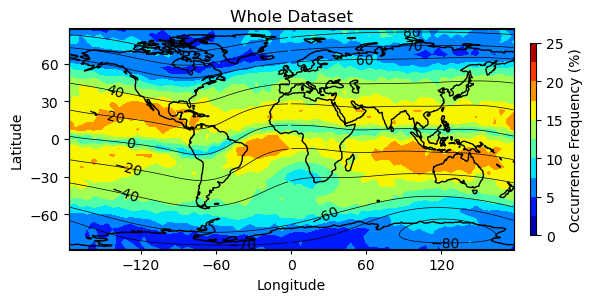

In [80]:
# Plot Occ Freq - whole dataset
#======================================

vmin = 0
vmax = 25

output_ds_file = 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_Whole_Dataset.nc'
if fivedegbins == 1:
    output_ds_file = 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_Whole_Dataset_5d.nc'
    
output_ds = xr.open_dataset(output_ds_file)
latout = output_ds['latitude']
lonout = output_ds['longitude']
ocfr_out = output_ds['ocfr_lon']



fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.PlateCarree()})
contour = ax.contourf(lonout, latout, ocfr_out, cmap='jet', levels=np.linspace(vmin, vmax, 11), vmin=vmin, vmax=vmax)

ax.coastlines()

ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude')
ax.set_yticks([-60,-30,0,30,60])
ax.set_ylabel('Latitude')

cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.03, aspect=30, shrink=0.5)
cbar.set_label('Occurrence Frequency (%)')

plt.title('Whole Dataset')


#============================================================================
ax2_cosmic = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())

ax2_cosmic.set_global()
contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]
contour = ax2_cosmic.contour(ALon, ALat, ALATM[0, :, :],
                      transform=ccrs.PlateCarree(),
                      colors='black',
                      levels=contour_levels, vmin=-90, vmax=90,
                      linestyles='solid',
                      linewidths=0.5
                      )

ax2_cosmic.patch.set_facecolor('none')
clabels = ax2_cosmic.clabel(contour, inline=True, fontsize=10)
#============================================================================


figname = f'OcFr_latlon_ds.png'
if fivedegbins == 1:
    figname = f'OcFr_latlon_ds_5d.png'

plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()

# COSMIC Data Processing: Occ Freq (lat-**lon**), Seasons

In [21]:
# Processing Normal Lat Lon coordinates
# Seasons separately
#======================================

# Define multiple sets of desired months
all_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11] , [12, 1, 2] ]

ds_length = np.arange(fdatetimes.shape[0])


# Loop over each set of desired months
for desired_months in all_desired_months:
    print('Months ' + str(desired_months))

    season = ""
    if set(desired_months) <= {12, 1, 2}:
        season = "winter"
    elif set(desired_months) <= {3, 4, 5}:
        season = "spring"
    elif set(desired_months) <= {6, 7, 8}:
        season = "summer"
    elif set(desired_months) <= {9, 10, 11}:
        season = "autumn"
    else:
        season = "unknown"
        
    print(season)
    
    averaging_period = 'Three-Month'
    
    freq_lon = np.zeros((lat_num_bins, lon_num_bins))
    nmeas_lon = np.zeros((lat_num_bins, lon_num_bins))
    ocfr_lon = np.zeros((lat_num_bins, lon_num_bins))    
 
    for i in tqdm(ds_length):
        current_lat = flat.values[i]
        current_lon = flon.values[i]
        current_s4max = fs4s.values[i]
        current_time = fdatetimes[i]
        current_month = current_time.month
        
        if current_month in desired_months:      
            lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
            lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1

            nmeas_lon[lat_bin_index, lon_bin_index] += 1.

            if not np.isnan(current_s4max):
                freq_lon[lat_bin_index, lon_bin_index] += 1.

    ocfr_lon = (freq_lon / nmeas_lon) * 100.0

    ###########################################################################################################################
    # Save occurrence frequency to nc file
    Ocfr_ds = xr.Dataset(
        data_vars={
            "ocfr_lon": (['latitude', 'longitude'], ocfr_lon),
        },
        coords={
            "latitude": lat_bin_midpoints,
            "longitude": lon_bin_midpoints,
        },
        attrs={
            'averaging_period': averaging_period,
        }
    )

    output_directory = "./Nc_Files/s4max/Daviddata/"
    output_file = f"{output_directory}Ocfr_Daviddata_{season}.nc"
    if fivedegbins == 1:
        output_file = f"{output_directory}Ocfr_Daviddata_{season}_5d.nc"
    Ocfr_ds.to_netcdf(output_file)

    ###########################################################################################################################


Months [3, 4, 5]
spring


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [01:10<00:00, 108855.45it/s]
/tmp/ipykernel_500277/4207898538.py:51: RuntimeWarning: invalid value encountered in divide
  ocfr_lon = (freq_lon / nmeas_lon) * 100.0


Months [6, 7, 8]
summer


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [01:10<00:00, 109099.01it/s]


Months [9, 10, 11]
autumn


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [01:09<00:00, 110767.25it/s]


Months [12, 1, 2]
winter


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [01:09<00:00, 110164.76it/s]


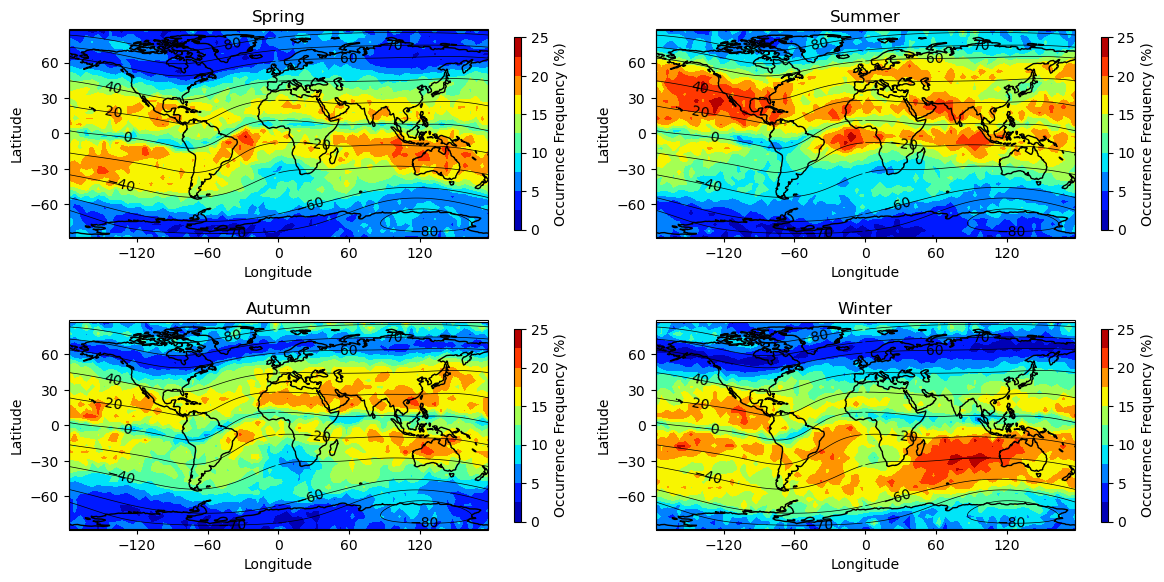

In [94]:
# Plot Occ Freq - seasons separately
#======================================


vmin = 0
vmax = 25

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# File paths for each season
file_paths = {
    'Spring': 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_spring.nc',
    'Summer': 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_summer.nc',
    'Autumn': 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_autumn.nc',
    'Winter': 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_winter.nc',
}

if fivedegbins == 1:
    file_paths = {
        'Spring': 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_spring_5d.nc',
        'Summer': 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_summer_5d.nc',
        'Autumn': 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_autumn_5d.nc',
        'Winter': 'Nc_Files/s4max/Daviddata/Ocfr_Daviddata_winter_5d.nc',
    }


fig, axes = plt.subplots(2, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

for i, (season, file_path) in enumerate(file_paths.items()):
    ax = axes.flatten()[i]

    # Load the data for the season
    output_ds = xr.open_dataset(file_path)
    latout = output_ds['latitude']
    lonout = output_ds['longitude']
    ocfr_out = output_ds['ocfr_lon']

    # Plot occurrence frequency
    contour = ax.contourf(lonout, latout, ocfr_out, cmap='jet', transform=ccrs.PlateCarree(), levels=np.linspace(vmin, vmax, 11), vmin=vmin, vmax=vmax)
    ax.coastlines()
    ax.set_title(season)

    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
    cbar.set_label('Occurrence Frequency (%)')

    # Add mag lat lines
    ax_mag_lat = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())
    ax_mag_lat.set_global()
    contour_mag_lat = ax_mag_lat.contour(ALon, ALat, ALATM[0, :, :],
                                        transform=ccrs.PlateCarree(),
                                        colors='black',
                                        levels=mag_lat_contour_levels,
                                        vmin=-90, vmax=90,
                                        linestyles='solid',
                                        linewidths=0.5
                                        )
    ax_mag_lat.patch.set_facecolor('none')
    clabels_mag_lat = ax_mag_lat.clabel(contour_mag_lat, inline=True, fontsize=10)

for ax in axes.flat:
    ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()

figname = f'OcFr_latlon_seasons.png'
if fivedegbins == 1:
    figname = f'OcFr_latlon_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')

plt.show()


# COSMIC Data Processing: Occ Freq (lat-**lon**), Seasons - INDIVIDUAL YRS

In [17]:
fdatetimes

# 2006-04-30 05:56:08.043825024
# ->
# 2019-12-10 12:39:50.466977536

# So:
# Spring years = 2007 - 2019 x13
# Spring years = 2007 - 2019 x14
# Spring years = 2007 - 2019 x14
# Spring years = 2007 - 2019 x13

0         2006-04-30 05:56:08.043825024
1         2006-04-30 05:56:36.604321920
2         2006-04-30 05:56:53.465184000
3         2006-04-30 06:01:05.802982400
4         2006-04-30 06:03:08.944861312
                       ...             
7657516   2019-12-10 11:30:26.465624576
7657517   2019-12-10 11:39:52.366115840
7657518   2019-12-10 11:48:34.206978560
7657519   2019-12-10 12:39:28.187154944
7657520   2019-12-10 12:39:50.466977536
Name: datetime, Length: 7657521, dtype: datetime64[ns]

In [176]:
# Process data - each year and season

year_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11], [12, 1,2] ]
all_desired_months = []

for d, seasonmonths in enumerate(year_desired_months):

    if set(seasonmonths) <= {3, 4, 5}:
        all_desired_months = [[3, 4, 5]]
        years_set = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        MAM_date_sets = [
            ['2007-03-01', '2007-05-31'], ['2008-03-01', '2008-05-31'], ['2009-03-01', '2009-05-31'],
            ['2010-03-01', '2010-05-31'], ['2011-03-01', '2011-05-31'], ['2012-03-01', '2012-05-31'],
            ['2013-03-01', '2013-05-31'], ['2014-03-01', '2014-05-31'], ['2015-03-01', '2015-05-31'],
            ['2016-03-01', '2016-05-31'], ['2017-03-01', '2017-05-31'], ['2018-03-01', '2018-05-31'],
            ['2019-03-01', '2019-05-31']
        ] 
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in MAM_date_sets]

    elif set(seasonmonths) <= {6, 7, 8}:
        
        all_desired_months = [[6, 7, 8]]
        years_set = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        JJA_date_sets = [
            ['2006-06-01', '2006-08-31'], ['2007-06-01', '2007-08-31'], ['2008-06-01', '2008-08-31'],
            ['2009-06-01', '2009-08-31'], ['2010-06-01', '2010-08-31'], ['2011-06-01', '2011-08-31'],
            ['2012-06-01', '2012-08-31'], ['2013-06-01', '2013-08-31'], ['2014-06-01', '2014-08-31'],
            ['2015-06-01', '2015-08-31'], ['2016-06-01', '2016-08-31'], ['2017-06-01', '2017-08-31'],
            ['2018-06-01', '2018-08-31'], ['2019-06-01', '2019-08-31']
        ]
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in JJA_date_sets]

    elif set(seasonmonths) <= {9, 10, 11}:
        all_desired_months = [[9, 10, 11]]
        years_set = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        SON_date_sets = [
            ['2006-09-01', '2006-11-30'], ['2007-09-01', '2007-11-30'], ['2008-09-01', '2008-11-30'],
            ['2009-09-01', '2009-11-30'], ['2010-09-01', '2010-11-30'], ['2011-09-01', '2011-11-30'],
            ['2012-09-01', '2012-11-30'], ['2013-09-01', '2013-11-30'], ['2014-09-01', '2014-11-30'],
            ['2015-09-01', '2015-11-30'], ['2016-09-01', '2016-11-30'], ['2017-09-01', '2017-11-30'],
            ['2018-09-01', '2018-11-30'], ['2019-09-01', '2019-11-30']
        ]
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in SON_date_sets]

    elif set(seasonmonths) <= {12, 1, 2}:
        all_desired_months = [[12, 1, 2]]
        years_set = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19']
        DJF_date_sets = [
            ['2006-12-01', '2007-02-28'], ['2007-12-01', '2008-02-29'], ['2008-12-01', '2009-02-28'],
            ['2009-12-01', '2010-02-28'], ['2010-12-01', '2011-02-28'], ['2011-12-01', '2012-02-29'],
            ['2012-12-01', '2013-02-28'], ['2013-12-01', '2014-02-28'], ['2014-12-01', '2015-02-28'],
            ['2015-12-01', '2016-02-29'], ['2016-12-01', '2017-02-28'], ['2017-12-01', '2018-02-28'],
            ['2018-12-01', '2019-02-28']
        ]
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in DJF_date_sets]
    else:
        print('error error error')

    # Find the index of the first value for the first date and the last index for the second date in each set
    indices_for_target_dates_sets = [
        [np.where(fdatetimes >= set_dates[0])[0].min(), np.where(fdatetimes <= set_dates[1])[0].max()] for set_dates in target_date_sets
    ]

    # Display the indices for each set of target dates
    for i, indices_for_target_dates in enumerate(indices_for_target_dates_sets):
        print(f'{years_set[i]} {all_desired_months}:')
        print(f"Indices for Target Dates Set {i + 1}: {indices_for_target_dates}")

        #dssl_alt = fhmEs[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_lat = flat[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_lon = flon[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_s4max = fs4s[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_time = fdatetimes[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]

        year = years_set[i]

        for desired_months in all_desired_months:

            season = ""
            if set(desired_months) <= {12, 1, 2}:
                season = "winter"
            elif set(desired_months) <= {3, 4, 5}:
                season = "spring"
            elif set(desired_months) <= {6, 7, 8}:
                season = "summer"
            elif set(desired_months) <= {9, 10, 11}:
                season = "autumn"
            else:
                season = "unknown"
            
            print({season})
            
            averaging_period = "Three-Month"

            freq_lon = np.zeros((lat_num_bins, lon_num_bins))
            nmeas_lon = np.zeros((lat_num_bins, lon_num_bins))
            ocfr_lon = np.zeros((lat_num_bins, lon_num_bins))    
     
            ###########################################################################################################################
            for i, value in tqdm(dssl_lat.items(), total=len(dssl_lat)):

                current_lat = dssl_lat[i]
                current_lon = dssl_lon[i]
                current_s4max = dssl_s4max[i]
                current_time = dssl_time[i]
                current_month = current_time.month
    
                if current_month in desired_months:      
                    lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
                    lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1

                    nmeas_lon[lat_bin_index, lon_bin_index] += 1.

                    if not np.isnan(current_s4max):
                        freq_lon[lat_bin_index, lon_bin_index] += 1.

            ocfr_lon = (freq_lon / nmeas_lon) * 100.0    
              
            
            
            ###########################################################################################################################
            # Save occurrence frequency to nc file
            Ocfr_ds = xr.Dataset(
                data_vars={
                    "ocfr_lon": (['latitude', 'longitude'], ocfr_lon),
                    "nmeas_lon": (['latitude', 'local_time'], nmeas_lon),
                    "freq_lon": (['latitude', 'local_time'], freq_lon),
                },
                coords={
                    "latitude": lat_bin_midpoints,
                    "longitude": lon_bin_midpoints,
                },
                attrs={
                    'year': year,
                    'averaging_period': averaging_period,
                    'season': season
               }
            )

            output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/lon/"
            
            output_file = f"{output_directory}Ocfr_Daviddata_{year}_{season}.nc"
            if fivedegbins == 1:
                output_file = f"{output_directory}Ocfr_Daviddata_{year}_{season}_5d.nc"
            Ocfr_ds.to_netcdf(output_file)

            ###########################################################################################################################


2007 [[3, 4, 5]]:
Indices for Target Dates Set 1: [498824, 762515]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263692/263692 [00:05<00:00, 47262.38it/s]


2008 [[3, 4, 5]]:
Indices for Target Dates Set 2: [1471493, 1695443]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223951/223951 [00:04<00:00, 47189.99it/s]


2009 [[3, 4, 5]]:
Indices for Target Dates Set 3: [2417170, 2663647]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246478/246478 [00:05<00:00, 47193.57it/s]


2010 [[3, 4, 5]]:
Indices for Target Dates Set 4: [3344758, 3550380]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205623/205623 [00:04<00:00, 47301.79it/s]


2011 [[3, 4, 5]]:
Indices for Target Dates Set 5: [4028729, 4201455]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172727/172727 [00:03<00:00, 47164.68it/s]


2012 [[3, 4, 5]]:
Indices for Target Dates Set 6: [4653582, 4786128]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132547/132547 [00:02<00:00, 47278.79it/s]


2013 [[3, 4, 5]]:
Indices for Target Dates Set 7: [5293488, 5469291]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175804/175804 [00:03<00:00, 47198.14it/s]


2014 [[3, 4, 5]]:
Indices for Target Dates Set 8: [5980100, 6115208]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135109/135109 [00:02<00:00, 47221.02it/s]


2015 [[3, 4, 5]]:
Indices for Target Dates Set 9: [6521555, 6646607]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125053/125053 [00:02<00:00, 47111.95it/s]


2016 [[3, 4, 5]]:
Indices for Target Dates Set 10: [6992539, 7083434]
{'spring'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90896/90896 [00:01<00:00, 47142.73it/s]


2017 [[3, 4, 5]]:
Indices for Target Dates Set 11: [7299058, 7345262]
{'spring'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46205/46205 [00:00<00:00, 47291.32it/s]
/tmp/ipykernel_805475/3945207970.py:117: RuntimeWarning: invalid value encountered in divide
  ocfr_lon = (freq_lon / nmeas_lon) * 100.0


2018 [[3, 4, 5]]:
Indices for Target Dates Set 12: [7470168, 7516260]
{'spring'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46093/46093 [00:00<00:00, 46865.21it/s]


2019 [[3, 4, 5]]:
Indices for Target Dates Set 13: [7609227, 7637072]
{'spring'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27846/27846 [00:00<00:00, 47402.59it/s]


2006 [[6, 7, 8]]:
Indices for Target Dates Set 1: [9218, 92564]
{'summer'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83347/83347 [00:01<00:00, 47053.21it/s]


2007 [[6, 7, 8]]:
Indices for Target Dates Set 2: [765546, 1020532]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254987/254987 [00:05<00:00, 47366.04it/s]


2008 [[6, 7, 8]]:
Indices for Target Dates Set 3: [1698102, 1936529]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238428/238428 [00:05<00:00, 47186.26it/s]


2009 [[6, 7, 8]]:
Indices for Target Dates Set 4: [2666322, 2881870]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215549/215549 [00:04<00:00, 47409.02it/s]


2010 [[6, 7, 8]]:
Indices for Target Dates Set 5: [3552369, 3755538]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203170/203170 [00:04<00:00, 47183.15it/s]


2011 [[6, 7, 8]]:
Indices for Target Dates Set 6: [4203720, 4381809]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178090/178090 [00:03<00:00, 47307.88it/s]


2012 [[6, 7, 8]]:
Indices for Target Dates Set 7: [4787279, 4907607]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120329/120329 [00:02<00:00, 47432.34it/s]


2013 [[6, 7, 8]]:
Indices for Target Dates Set 8: [5471204, 5660922]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189719/189719 [00:04<00:00, 47360.74it/s]


2014 [[6, 7, 8]]:
Indices for Target Dates Set 9: [6116419, 6271370]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154952/154952 [00:03<00:00, 47199.91it/s]


2015 [[6, 7, 8]]:
Indices for Target Dates Set 10: [6648229, 6787700]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139472/139472 [00:02<00:00, 47247.95it/s]


2016 [[6, 7, 8]]:
Indices for Target Dates Set 11: [7084453, 7165810]
{'summer'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81358/81358 [00:01<00:00, 47085.81it/s]


2017 [[6, 7, 8]]:
Indices for Target Dates Set 12: [7345566, 7379826]
{'summer'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34261/34261 [00:00<00:00, 47182.69it/s]


2018 [[6, 7, 8]]:
Indices for Target Dates Set 13: [7516824, 7546373]
{'summer'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29550/29550 [00:00<00:00, 47138.45it/s]


2019 [[6, 7, 8]]:
Indices for Target Dates Set 14: [7637073, 7643026]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5954/5954 [00:00<00:00, 46459.89it/s]


2006 [[9, 10, 11]]:
Indices for Target Dates Set 1: [94451, 266863]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172413/172413 [00:03<00:00, 47032.76it/s]


2007 [[9, 10, 11]]:
Indices for Target Dates Set 2: [1023349, 1215036]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191688/191688 [00:04<00:00, 47209.56it/s]


2008 [[9, 10, 11]]:
Indices for Target Dates Set 3: [1938627, 2164544]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225918/225918 [00:04<00:00, 47271.57it/s]


2009 [[9, 10, 11]]:
Indices for Target Dates Set 4: [2884449, 3109134]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224686/224686 [00:04<00:00, 46974.53it/s]


2010 [[9, 10, 11]]:
Indices for Target Dates Set 5: [3757168, 3891441]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134274/134274 [00:02<00:00, 47310.32it/s]


2011 [[9, 10, 11]]:
Indices for Target Dates Set 6: [4383658, 4524843]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141186/141186 [00:02<00:00, 47270.25it/s]


2012 [[9, 10, 11]]:
Indices for Target Dates Set 7: [4909106, 5101284]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192179/192179 [00:04<00:00, 47015.16it/s]


2013 [[9, 10, 11]]:
Indices for Target Dates Set 8: [5663008, 5822510]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159503/159503 [00:03<00:00, 47415.99it/s]


2014 [[9, 10, 11]]:
Indices for Target Dates Set 9: [6272337, 6405115]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132779/132779 [00:02<00:00, 47239.04it/s]


2015 [[9, 10, 11]]:
Indices for Target Dates Set 10: [6789067, 6909437]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120371/120371 [00:02<00:00, 47223.32it/s]


2016 [[9, 10, 11]]:
Indices for Target Dates Set 11: [7166529, 7235019]
{'autumn'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68491/68491 [00:01<00:00, 47262.53it/s]


2017 [[9, 10, 11]]:
Indices for Target Dates Set 12: [7380060, 7425208]
{'autumn'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45149/45149 [00:00<00:00, 46885.16it/s]


2018 [[9, 10, 11]]:
Indices for Target Dates Set 13: [7546902, 7579553]
{'autumn'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32652/32652 [00:00<00:00, 47148.90it/s]


2019 [[9, 10, 11]]:
Indices for Target Dates Set 14: [7643027, 7655889]
{'autumn'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12863/12863 [00:00<00:00, 46967.01it/s]


2006-7 [[12, 1, 2]]:
Indices for Target Dates Set 1: [269212, 495544]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226333/226333 [00:04<00:00, 47295.65it/s]


2007-8 [[12, 1, 2]]:
Indices for Target Dates Set 2: [1216944, 1468855]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251912/251912 [00:05<00:00, 47017.69it/s]


2008-9 [[12, 1, 2]]:
Indices for Target Dates Set 3: [2167524, 2414797]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247274/247274 [00:05<00:00, 47023.98it/s]


2009-10 [[12, 1, 2]]:
Indices for Target Dates Set 4: [3111388, 3342116]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230729/230729 [00:04<00:00, 46910.20it/s]


2010-11 [[12, 1, 2]]:
Indices for Target Dates Set 5: [3892455, 4027371]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134917/134917 [00:02<00:00, 47159.49it/s]


2011-12 [[12, 1, 2]]:
Indices for Target Dates Set 6: [4526747, 4652222]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125476/125476 [00:02<00:00, 47064.54it/s]


2012-13 [[12, 1, 2]]:
Indices for Target Dates Set 7: [5103521, 5291541]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188021/188021 [00:03<00:00, 47071.06it/s]


2013-14 [[12, 1, 2]]:
Indices for Target Dates Set 8: [5824666, 5978133]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153468/153468 [00:03<00:00, 47506.24it/s]


2014-15 [[12, 1, 2]]:
Indices for Target Dates Set 9: [6406493, 6520142]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113650/113650 [00:02<00:00, 47521.76it/s]


2015-16 [[12, 1, 2]]:
Indices for Target Dates Set 10: [6910785, 6991425]
{'winter'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80641/80641 [00:01<00:00, 47158.30it/s]


2016-17 [[12, 1, 2]]:
Indices for Target Dates Set 11: [7235231, 7298026]
{'winter'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62796/62796 [00:01<00:00, 47054.34it/s]


2017-18 [[12, 1, 2]]:
Indices for Target Dates Set 12: [7425279, 7469484]
{'winter'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44206/44206 [00:00<00:00, 47171.70it/s]


2018-19 [[12, 1, 2]]:
Indices for Target Dates Set 13: [7579841, 7608687]
{'winter'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28847/28847 [00:00<00:00, 47247.24it/s]


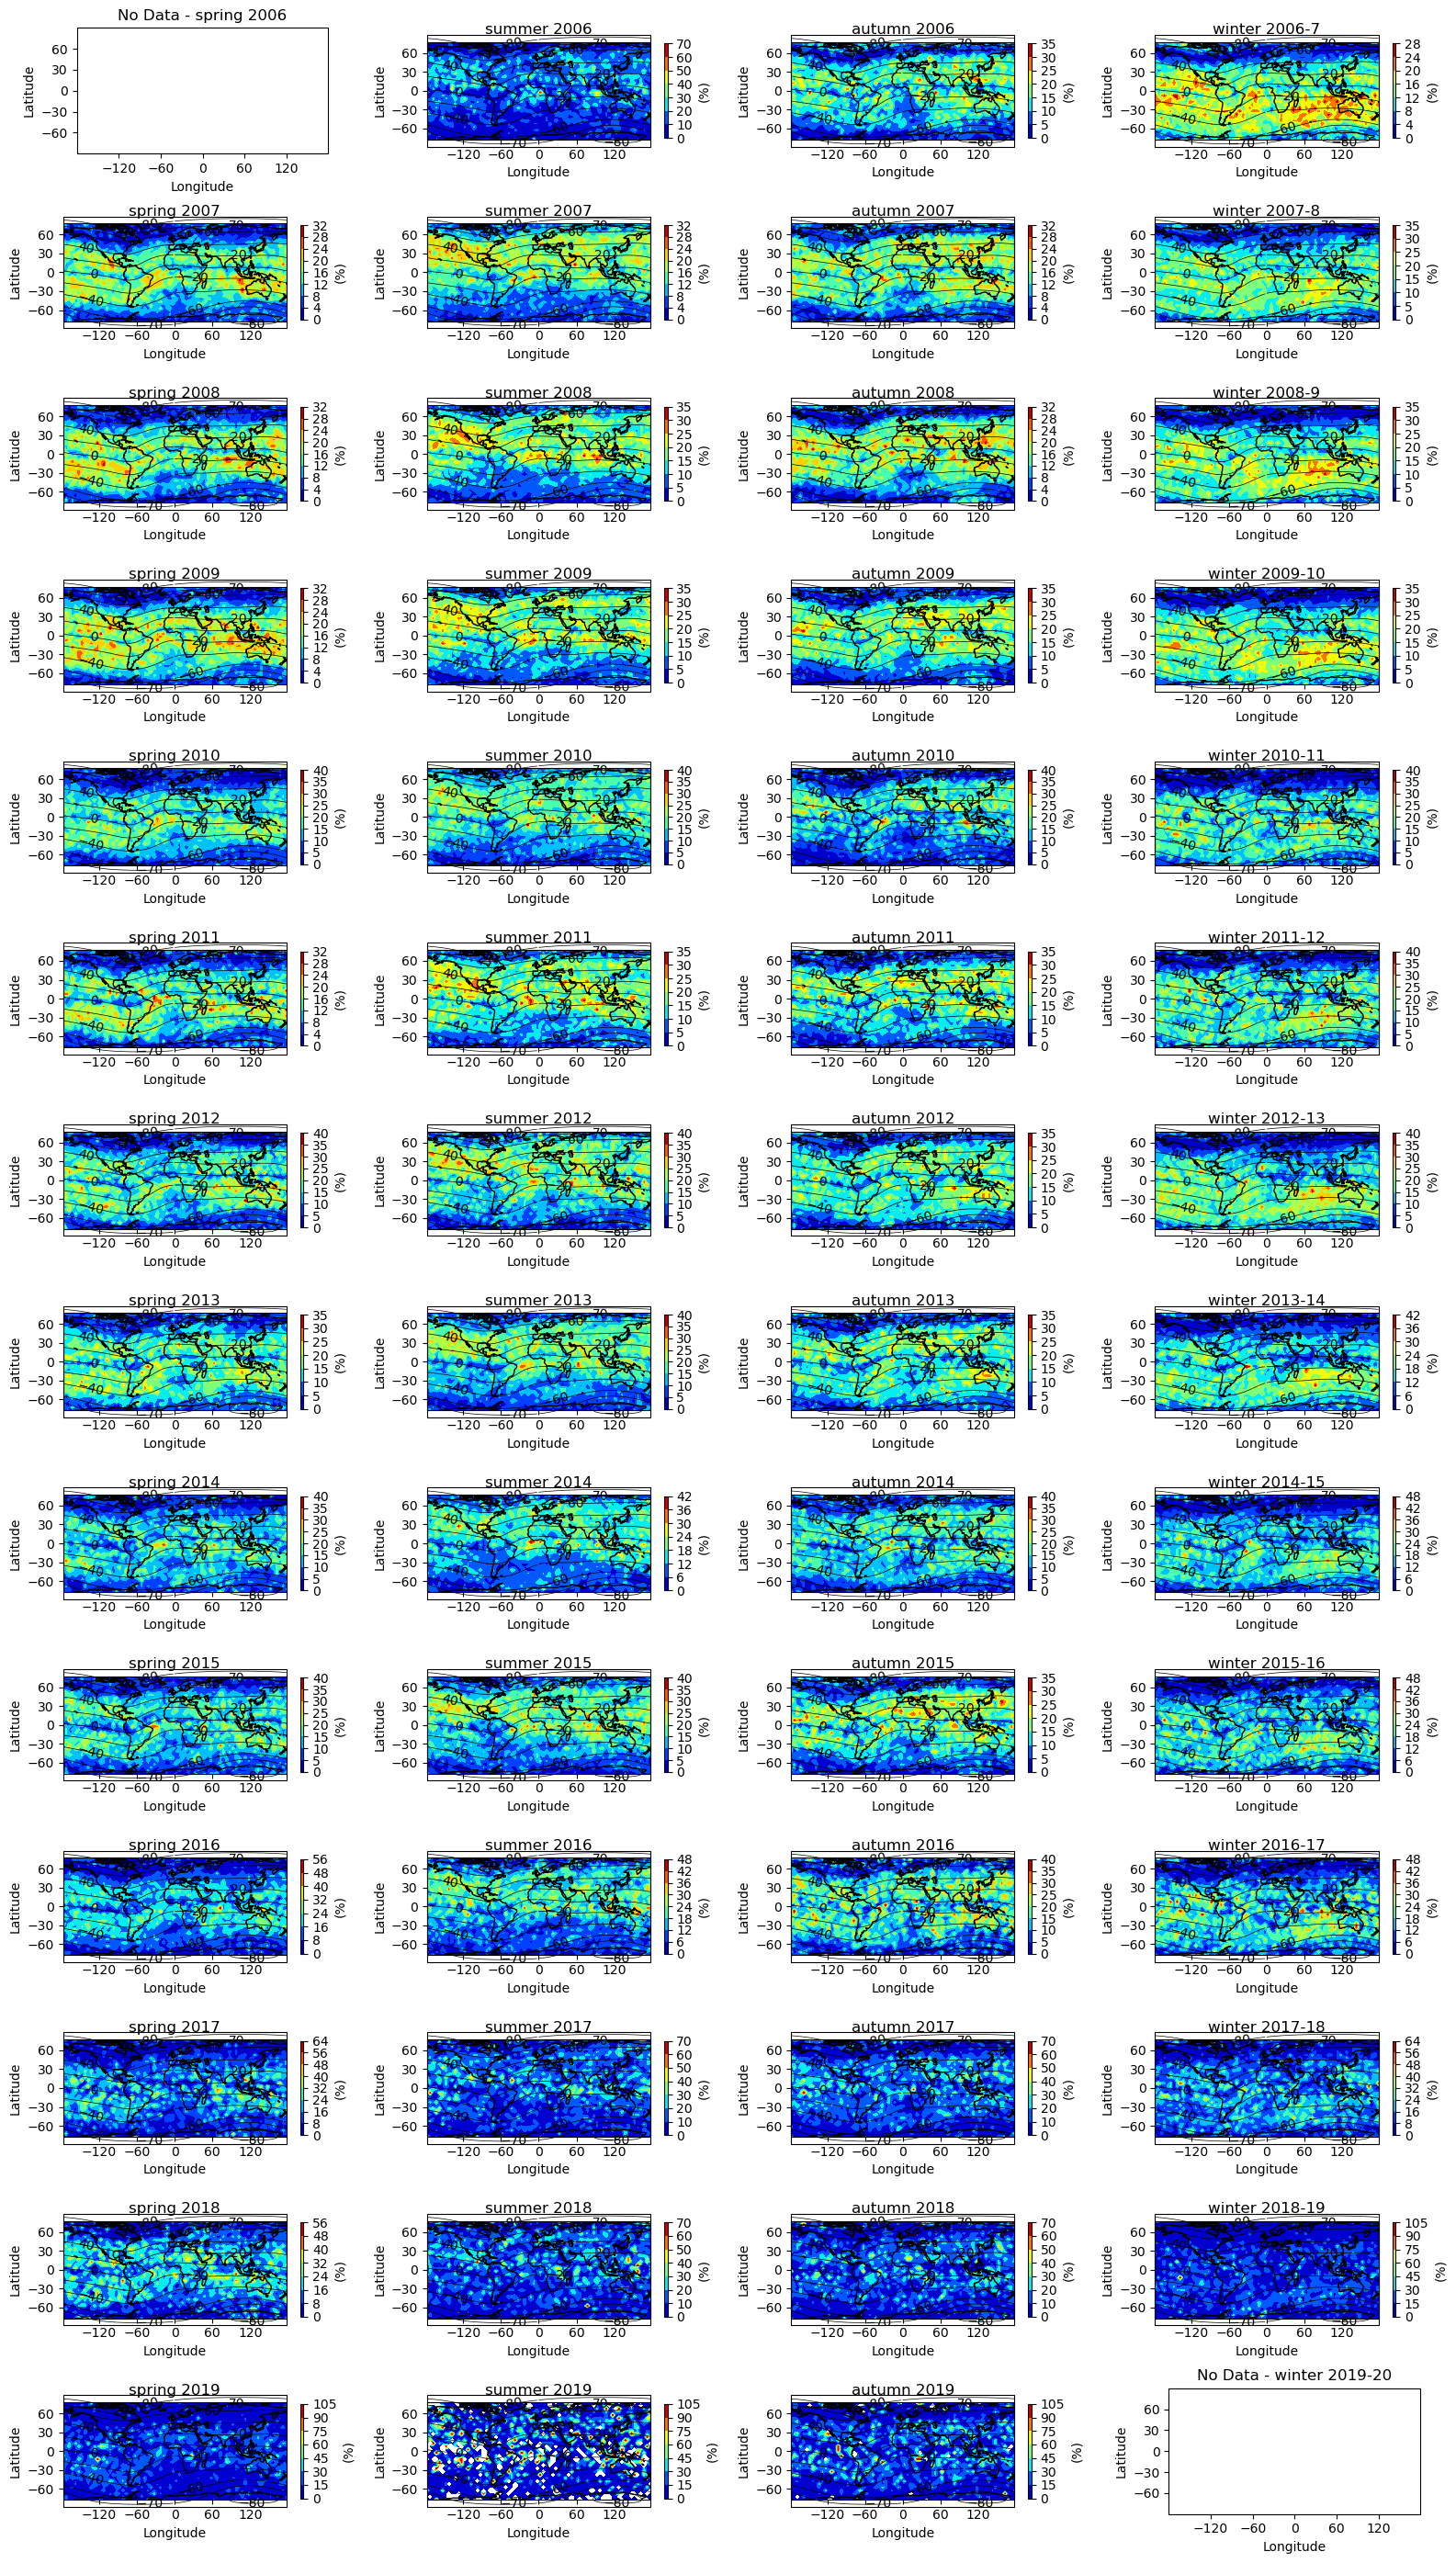

In [132]:
## PLOT ocfr_lon ##
# ALL SEASONS/YEARS #

# Define constants
vmin = 0
vmax = 50
nolevs = 11

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# Define seasons and years
seasons = ['spring', 'summer', 'autumn', 'winter']
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
winter_years = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

# Define the directory containing individual year files
data_directory = './Nc_Files/s4max/Daviddata/Individual_yrs/lon/'

# Create a subplot for each year
fig, axes = plt.subplots(len(years), len(seasons), figsize=(16, 28), subplot_kw={'projection': ccrs.PlateCarree()})

for i, year in enumerate(years):
    for j, season in enumerate(seasons):
        ax = axes[i, j]

        file_path = ''
        # Construct file path for the current season and year
        if season == 'winter':
            year = winter_years[i]
            year_start = int(year.split('-')[0])
            year_end = int(year.split('-')[1])
            file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_5d.nc'
        else:
            file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_5d.nc'

        # Check if the file exists
        if os.path.exists(file_path):
            # Load data for the current season and year
            output_ds = xr.open_dataset(file_path)
            latout = output_ds['latitude']
            lonout = output_ds['longitude']
            ocfr_out = output_ds['ocfr_lon']
            # nmeas_lon_out = output_ds['nmeas_lon']
            # freq_lon_out = output_ds['freq_lon']

            # lat_indices = np.where((latout >= -80) & (latout <= 80))[0]
            # latout_slice = latout[lat_indices]
            # ocfr_out_slice = ocfr_out[lat_indices,:]
            
            # Plot occurrence frequency
            contour = ax.contourf(lonout, latout, ocfr_out, cmap='jet', transform=ccrs.PlateCarree()
                                #, levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                                 )
            ax.coastlines()
            ax.set_title(f'{season} {year}')

            # Add colorbar
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
            cbar.set_label('(%)')

            # Add mag lat lines
            ax_mag_lat = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())
            ax_mag_lat.set_global()
            contour_mag_lat = ax_mag_lat.contour(ALon, ALat, ALATM[0, :, :],
                                                  transform=ccrs.PlateCarree(),
                                                  colors='black',
                                                  levels=mag_lat_contour_levels,
                                                  vmin=-90, vmax=90,
                                                  linestyles='solid',
                                                  linewidths=0.5
                                                  )
            ax_mag_lat.patch.set_facecolor('none')
            clabels_mag_lat = ax_mag_lat.clabel(contour_mag_lat, inline=True, fontsize=10)
        else:
            # If the file doesn't exist, skip plotting and set title as 'No Data'
            ax.set_title(f'No Data - {season} {year}')

# Set common labels and ticks for all subplots
for ax in axes.flat:
    ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()

figname = f'OcFr_latlon_years_seasons.png'
if fivedegbins == 1:
    figname = f'OcFr_latlon_years_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')


plt.show()


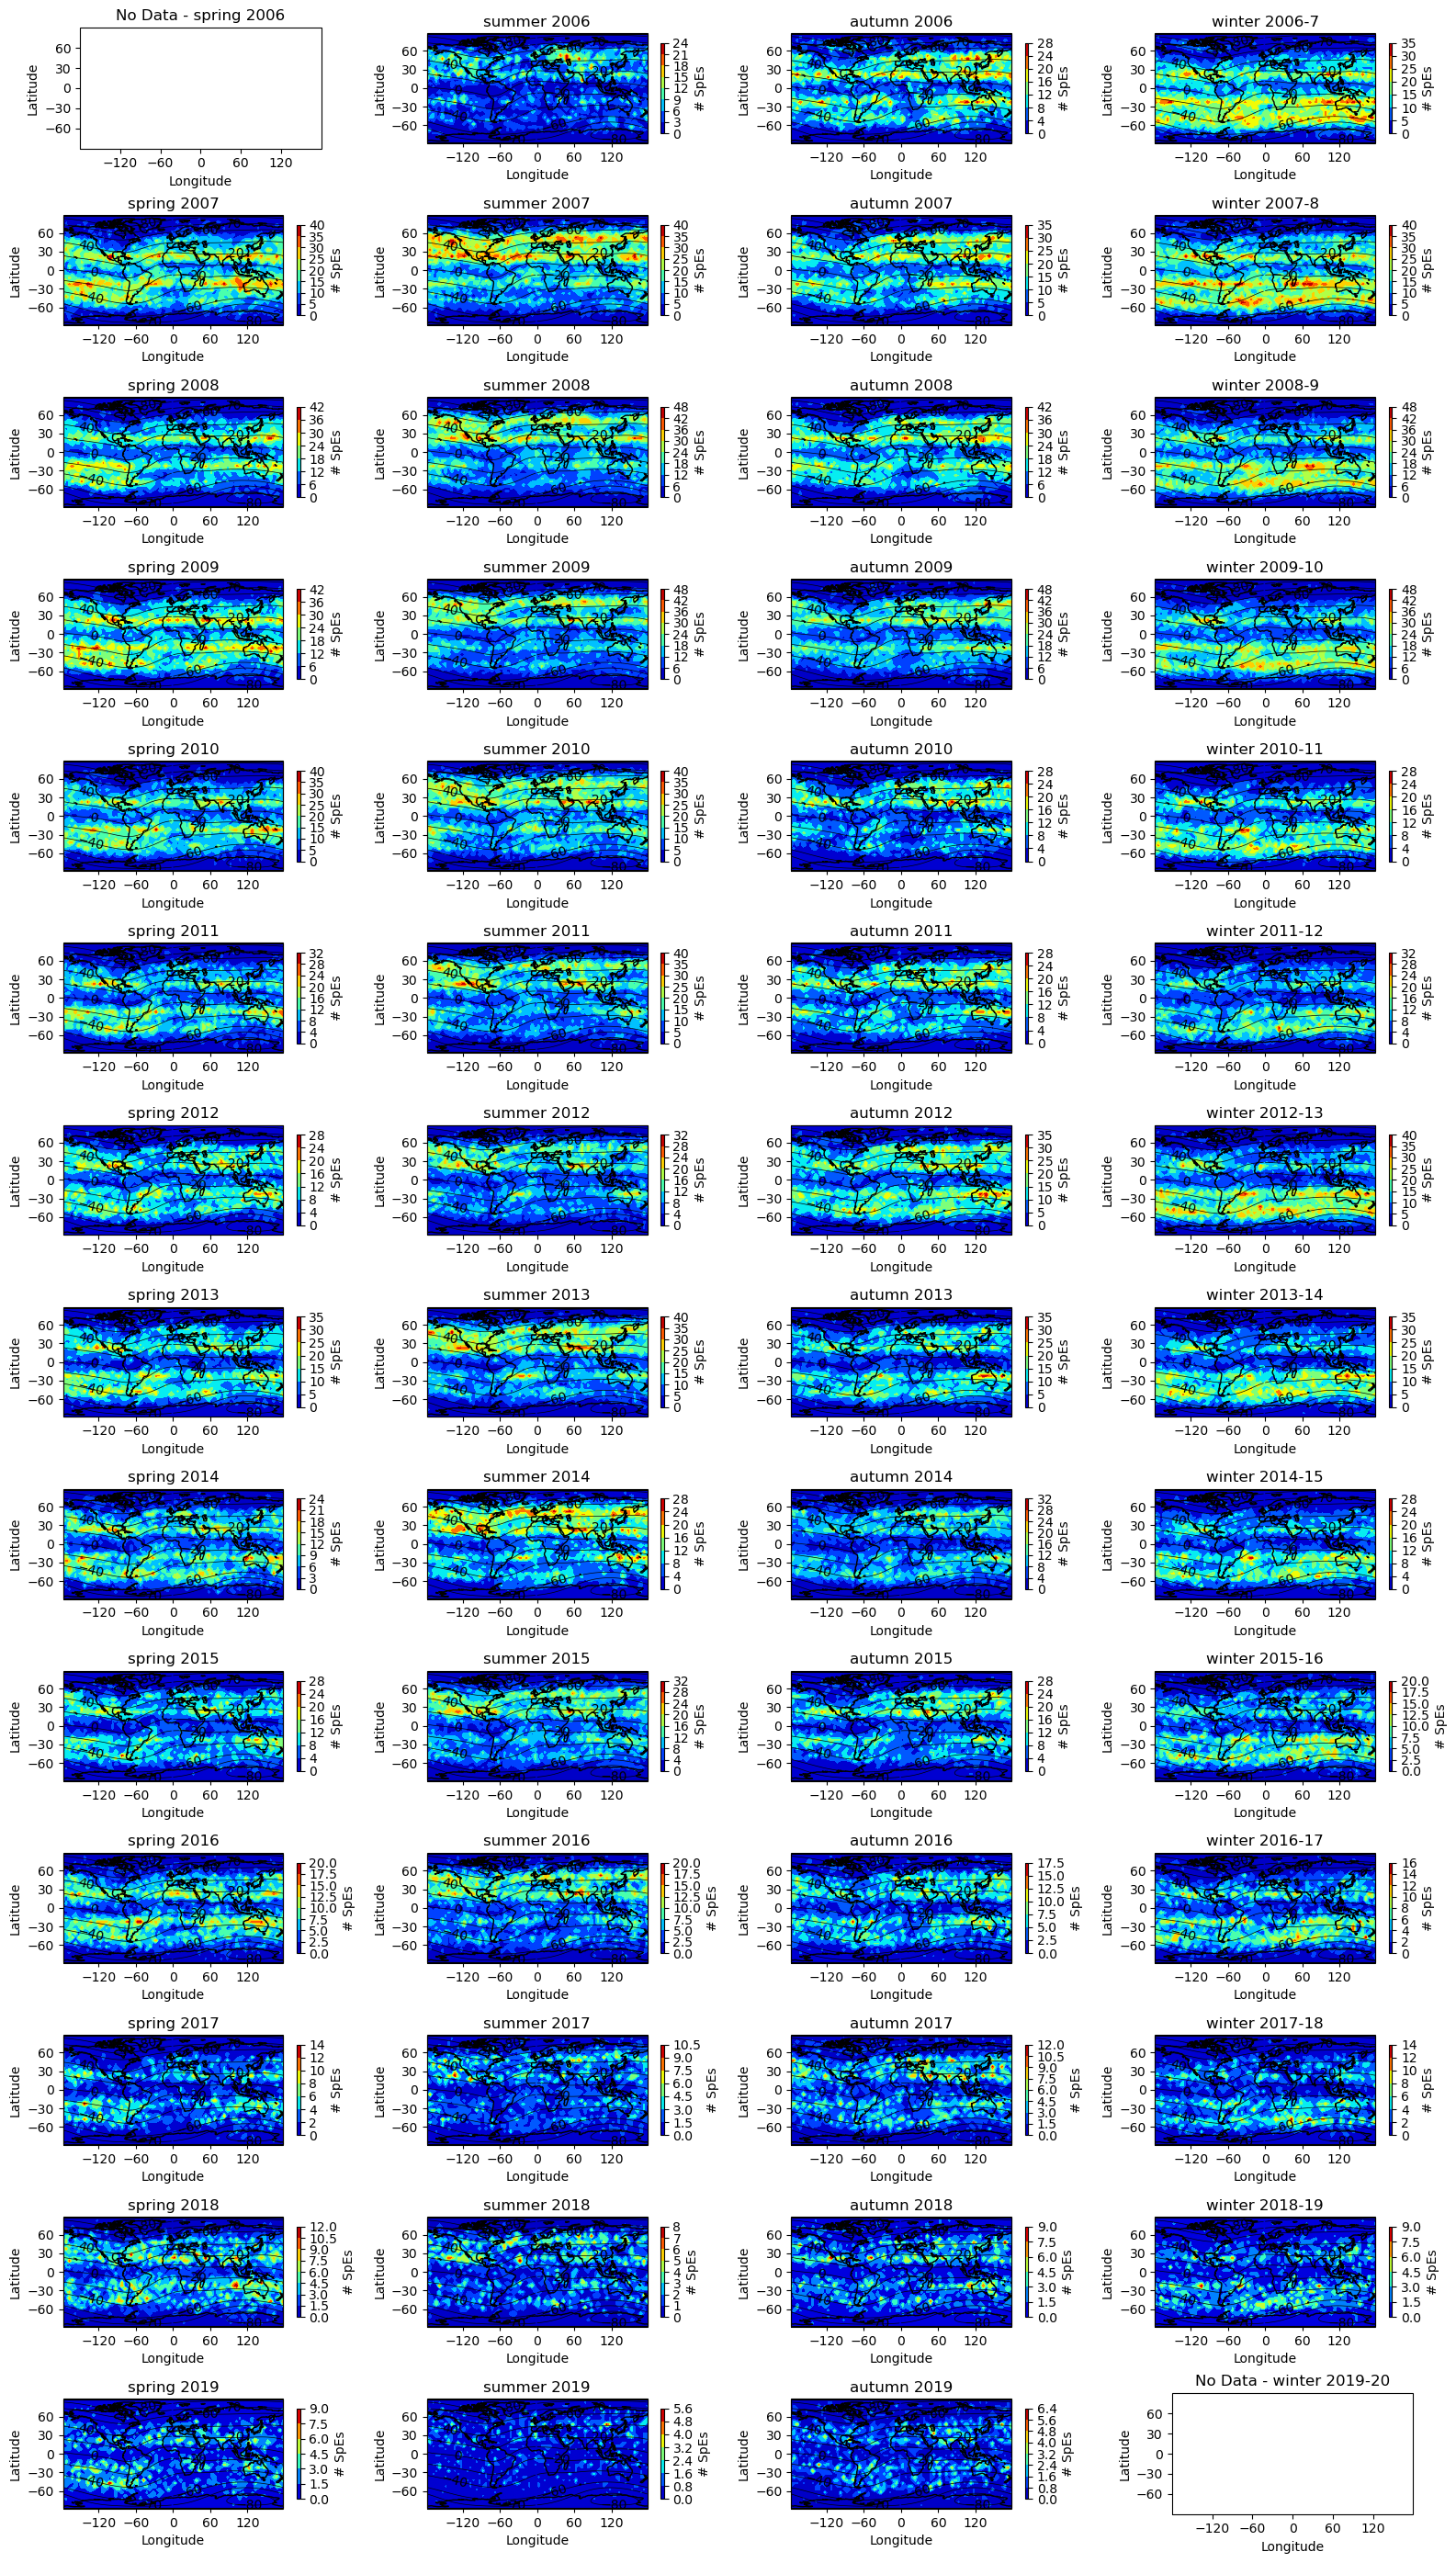

In [188]:
## PLOT nmeas_lon and freq_lon ##
# ALL SEASONS/YEARS #

# Define constants
vmin = 0
vmax = 50
nolevs = 11

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# Define seasons and years
seasons = ['spring', 'summer', 'autumn', 'winter']
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
winter_years = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

# Define the directory containing individual year files
data_directory = './Nc_Files/s4max/Daviddata/Individual_yrs/lon/'

# Create a subplot for each year
fig, axes = plt.subplots(len(years), len(seasons), figsize=(16, 28), subplot_kw={'projection': ccrs.PlateCarree()})

for i, year in enumerate(years):
    for j, season in enumerate(seasons):
        ax = axes[i, j]

        file_path = ''
        # Construct file path for the current season and year
        if season == 'winter':
            year = winter_years[i]
            year_start = int(year.split('-')[0])
            year_end = int(year.split('-')[1])
            file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_5d.nc'
        else:
            file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_5d.nc'

        # Check if the file exists
        if os.path.exists(file_path):
            # Load data for the current season and year
            output_ds = xr.open_dataset(file_path)
            latout = output_ds['latitude']
            lonout = output_ds['longitude']
            ocfr_out = output_ds['ocfr_lon']
            nmeas_lon_out = output_ds['nmeas_lon']
            freq_lon_out = output_ds['freq_lon']

            # lat_indices = np.where((latout >= -80) & (latout <= 80))[0]
            # latout_slice = latout[lat_indices]
            # ocfr_out_slice = ocfr_out[lat_indices,:]
            
            # Plot occurrence frequency
            contour = ax.contourf(lonout, latout, freq_lon_out, cmap='jet', transform=ccrs.PlateCarree()
                                #, levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                                 )
            ax.coastlines()
            ax.set_title(f'{season} {year}')

            # Add colorbar
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
            cbar.set_label('# SpEs')
            #cbar.set_label('Total Measurements')

            # Add mag lat lines
            ax_mag_lat = fig.add_subplot(ax.get_subplotspec(), projection=ccrs.PlateCarree())
            ax_mag_lat.set_global()
            contour_mag_lat = ax_mag_lat.contour(ALon, ALat, ALATM[0, :, :],
                                                  transform=ccrs.PlateCarree(),
                                                  colors='black',
                                                  levels=mag_lat_contour_levels,
                                                  vmin=-90, vmax=90,
                                                  linestyles='solid',
                                                  linewidths=0.5
                                                  )
            ax_mag_lat.patch.set_facecolor('none')
            clabels_mag_lat = ax_mag_lat.clabel(contour_mag_lat, inline=True, fontsize=10)
        else:
            # If the file doesn't exist, skip plotting and set title as 'No Data'
            ax.set_title(f'No Data - {season} {year}')

# Set common labels and ticks for all subplots
for ax in axes.flat:
    ax.set_xticks([-120, -60, 0, 60, 120], crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()


if fivedegbins == 1:
    #figname = f'n_meas_latlon_years_seasons_5d_.png'
    figname = f'n_SpEs_latlon_years_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')


plt.show()


# COSMIC Data Processing: Occ Freq (lat-**LT**), Seasons 

In [95]:
# Processing Normal Lat Lon coordinates
# Seasons separately
#======================================

# Define multiple sets of desired months
all_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11] , [12, 1, 2] ]
month_to_season = {
    (12, 1, 2): "winter",
    (3, 4, 5): "spring",
    (6, 7, 8): "summer",
    (9, 10, 11): "autumn" }
 
ds_length = np.arange(fdatetimes.shape[0])


# Loop over each set of desired months
for desired_months in all_desired_months:
    print('Months ' + str(desired_months))

    season = month_to_season.get(tuple(desired_months), "unknown")
        
    print(season)
    
    averaging_period = 'Three-Month'
    
    freq_LT = np.zeros((lat_num_bins, LT_num_bins))
    nmeas_LT = np.zeros((lat_num_bins, LT_num_bins))
    ocfr_LT = np.zeros((lat_num_bins, LT_num_bins))   

    for i in tqdm(ds_length):
        current_lat = flat.values[i]
        #current_lon = flon.values[i]
        
        current_LT = local_times[i]
        time_part = current_LT.hour + current_LT.minute / 60 + current_LT.second / 3600
        
        current_s4max = fs4s.values[i]
        
        current_time = fdatetimes[i]
        current_month = current_time.month
        
        if current_month in desired_months:      
            lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
            #lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1
            LT_bin_index = np.digitize(time_part, LT_bin_edges) - 1
            
            nmeas_LT[lat_bin_index, LT_bin_index] += 1.

            if not np.isnan(current_s4max):
                freq_LT[lat_bin_index, LT_bin_index] += 1.

    ocfr_LT = (freq_LT / nmeas_LT) * 100.0

    ###########################################################################################################################
    # Save occurrence frequency to nc file
    Ocfr_ds = xr.Dataset(
        data_vars={
            "ocfr_LT": (['latitude', 'local_time'], ocfr_LT),
        },
        coords={
            "latitude": lat_bin_midpoints,
            "local_time": LT_bin_midpoints,
        },
        attrs={
            'averaging_period': averaging_period,
        }
    )

    output_directory = "./Nc_Files/s4max/Daviddata/"
    output_file = f"{output_directory}Ocfr_Daviddata_{season}_LT.nc"
    if fivedegbins == 1:
        output_file = f"{output_directory}Ocfr_Daviddata_{season}_LT_5d.nc"
    Ocfr_ds.to_netcdf(output_file)

    ###########################################################################################################################


Months [3, 4, 5]
spring


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [01:06<00:00, 114438.94it/s]


Months [6, 7, 8]
summer


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [01:07<00:00, 114169.93it/s]


Months [9, 10, 11]
autumn


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [01:06<00:00, 115401.33it/s]


Months [12, 1, 2]
winter


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [01:06<00:00, 114719.42it/s]


# COSMIC Data Processing: Occ Freq (lat-**LT**), Seasons Separately - INDIVIDUAL YEARS

In [174]:
# Process data - each year and season

year_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11], [12, 1,2] ]
all_desired_months = []

for d, seasonmonths in enumerate(year_desired_months):

    if set(seasonmonths) <= {3, 4, 5}:
        all_desired_months = [[3, 4, 5]]
        years_set = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        MAM_date_sets = [
            ['2007-03-01', '2007-05-31'], ['2008-03-01', '2008-05-31'], ['2009-03-01', '2009-05-31'],
            ['2010-03-01', '2010-05-31'], ['2011-03-01', '2011-05-31'], ['2012-03-01', '2012-05-31'],
            ['2013-03-01', '2013-05-31'], ['2014-03-01', '2014-05-31'], ['2015-03-01', '2015-05-31'],
            ['2016-03-01', '2016-05-31'], ['2017-03-01', '2017-05-31'], ['2018-03-01', '2018-05-31'],
            ['2019-03-01', '2019-05-31']
        ] 
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in MAM_date_sets]

    elif set(seasonmonths) <= {6, 7, 8}:
        
        all_desired_months = [[6, 7, 8]]
        years_set = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        JJA_date_sets = [
            ['2006-06-01', '2006-08-31'], ['2007-06-01', '2007-08-31'], ['2008-06-01', '2008-08-31'],
            ['2009-06-01', '2009-08-31'], ['2010-06-01', '2010-08-31'], ['2011-06-01', '2011-08-31'],
            ['2012-06-01', '2012-08-31'], ['2013-06-01', '2013-08-31'], ['2014-06-01', '2014-08-31'],
            ['2015-06-01', '2015-08-31'], ['2016-06-01', '2016-08-31'], ['2017-06-01', '2017-08-31'],
            ['2018-06-01', '2018-08-31'], ['2019-06-01', '2019-08-31']
        ]
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in JJA_date_sets]

    elif set(seasonmonths) <= {9, 10, 11}:
        all_desired_months = [[9, 10, 11]]
        years_set = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
        SON_date_sets = [
            ['2006-09-01', '2006-11-30'], ['2007-09-01', '2007-11-30'], ['2008-09-01', '2008-11-30'],
            ['2009-09-01', '2009-11-30'], ['2010-09-01', '2010-11-30'], ['2011-09-01', '2011-11-30'],
            ['2012-09-01', '2012-11-30'], ['2013-09-01', '2013-11-30'], ['2014-09-01', '2014-11-30'],
            ['2015-09-01', '2015-11-30'], ['2016-09-01', '2016-11-30'], ['2017-09-01', '2017-11-30'],
            ['2018-09-01', '2018-11-30'], ['2019-09-01', '2019-11-30']
        ]
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in SON_date_sets]

    elif set(seasonmonths) <= {12, 1, 2}:
        all_desired_months = [[12, 1, 2]]
        years_set = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19']
        DJF_date_sets = [
            ['2006-12-01', '2007-02-28'], ['2007-12-01', '2008-02-29'], ['2008-12-01', '2009-02-28'],
            ['2009-12-01', '2010-02-28'], ['2010-12-01', '2011-02-28'], ['2011-12-01', '2012-02-29'],
            ['2012-12-01', '2013-02-28'], ['2013-12-01', '2014-02-28'], ['2014-12-01', '2015-02-28'],
            ['2015-12-01', '2016-02-29'], ['2016-12-01', '2017-02-28'], ['2017-12-01', '2018-02-28'],
            ['2018-12-01', '2019-02-28']
        ]
        target_date_sets = [[pd.to_datetime(date) for date in set_dates] for set_dates in DJF_date_sets]
    else:
        print('error error error')

    # Find the index of the first value for the first date and the last index for the second date in each set
    indices_for_target_dates_sets = [
        [np.where(fdatetimes >= set_dates[0])[0].min(), np.where(fdatetimes <= set_dates[1])[0].max()] for set_dates in target_date_sets
    ]

    # Display the indices for each set of target dates
    for i, indices_for_target_dates in enumerate(indices_for_target_dates_sets):
        print(f'{years_set[i]} {all_desired_months}:')
        print(f"Indices for Target Dates Set {i + 1}: {indices_for_target_dates}")

        #dssl_alt = fhmEs[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_lat = flat[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_lon = flon[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_s4max = fs4s[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        dssl_time = fdatetimes[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]

        dssl_LT = local_times[indices_for_target_dates[0]: indices_for_target_dates[1] + 1]
        
        year = years_set[i]

        for desired_months in all_desired_months:

            season = ""
            if set(desired_months) <= {12, 1, 2}:
                season = "winter"
            elif set(desired_months) <= {3, 4, 5}:
                season = "spring"
            elif set(desired_months) <= {6, 7, 8}:
                season = "summer"
            elif set(desired_months) <= {9, 10, 11}:
                season = "autumn"
            else:
                season = "unknown"
            
            print({season})
            
            averaging_period = "Three-Month"

            freq_LT = np.zeros((lat_num_bins, LT_num_bins))
            nmeas_LT = np.zeros((lat_num_bins, LT_num_bins))
            ocfr_LT = np.zeros((lat_num_bins, LT_num_bins))  

            ###########################################################################################################################

            for idx, (i, _) in tqdm(enumerate(dssl_lat.items()), total=len(dssl_lat)):
                # print(f'i= {i}')
                # print(f'idx= {idx}')
                
                current_lat = dssl_lat[i]
                #current_lon = dssl_lon[i]
                current_s4max = dssl_s4max[i]
                
                current_time = dssl_time[i]
                current_month = current_time.month
    
                current_LT = dssl_LT[idx]
                time_part = current_LT.hour + current_LT.minute / 60 + current_LT.second / 3600
    
                if current_month in desired_months:      
                    lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
                    LT_bin_index = np.digitize(time_part, LT_bin_edges) - 1
            
                    nmeas_LT[lat_bin_index, LT_bin_index] += 1.

                    if not np.isnan(current_s4max):
                        freq_LT[lat_bin_index, LT_bin_index] += 1.

            ocfr_LT = (freq_LT / nmeas_LT) * 100.0

            ###########################################################################################################################
            # Save occurrence frequency to nc file
            Ocfr_ds = xr.Dataset(
                data_vars={
                    "ocfr_LT": (['latitude', 'local_time'], ocfr_LT),
                    "nmeas_LT": (['latitude', 'local_time'], nmeas_LT),
                    "freq_LT": (['latitude', 'local_time'], freq_LT),
                },
                coords={
                    "latitude": lat_bin_midpoints,
                    "local_time": LT_bin_midpoints,
                },
                attrs={
                    'year': year,
                    'averaging_period': averaging_period,
                    'season': season
               }
            )

            output_directory = "./Nc_Files/s4max/Daviddata/Individual_yrs/LT/"
            
            output_file = f"{output_directory}Ocfr_Daviddata_{year}_{season}_LT.nc"
            if fivedegbins == 1:
                output_file = f"{output_directory}Ocfr_Daviddata_{year}_{season}_LT_5d.nc"
            Ocfr_ds.to_netcdf(output_file)

            ###########################################################################################################################


2007 [[3, 4, 5]]:
Indices for Target Dates Set 1: [498824, 762515]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263692/263692 [00:05<00:00, 52030.92it/s]


2008 [[3, 4, 5]]:
Indices for Target Dates Set 2: [1471493, 1695443]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223951/223951 [00:04<00:00, 52208.58it/s]


2009 [[3, 4, 5]]:
Indices for Target Dates Set 3: [2417170, 2663647]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 246478/246478 [00:04<00:00, 52304.22it/s]


2010 [[3, 4, 5]]:
Indices for Target Dates Set 4: [3344758, 3550380]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205623/205623 [00:03<00:00, 51975.07it/s]


2011 [[3, 4, 5]]:
Indices for Target Dates Set 5: [4028729, 4201455]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172727/172727 [00:03<00:00, 52244.85it/s]


2012 [[3, 4, 5]]:
Indices for Target Dates Set 6: [4653582, 4786128]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132547/132547 [00:02<00:00, 52089.92it/s]


2013 [[3, 4, 5]]:
Indices for Target Dates Set 7: [5293488, 5469291]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175804/175804 [00:03<00:00, 51940.20it/s]


2014 [[3, 4, 5]]:
Indices for Target Dates Set 8: [5980100, 6115208]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135109/135109 [00:02<00:00, 52028.89it/s]


2015 [[3, 4, 5]]:
Indices for Target Dates Set 9: [6521555, 6646607]
{'spring'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125053/125053 [00:02<00:00, 51884.53it/s]


2016 [[3, 4, 5]]:
Indices for Target Dates Set 10: [6992539, 7083434]
{'spring'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90896/90896 [00:01<00:00, 52063.89it/s]


2017 [[3, 4, 5]]:
Indices for Target Dates Set 11: [7299058, 7345262]
{'spring'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46205/46205 [00:00<00:00, 51560.03it/s]
/tmp/ipykernel_805475/1592149542.py:126: RuntimeWarning: invalid value encountered in divide
  ocfr_LT = (freq_LT / nmeas_LT) * 100.0


2018 [[3, 4, 5]]:
Indices for Target Dates Set 12: [7470168, 7516260]
{'spring'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46093/46093 [00:01<00:00, 44115.74it/s]


2019 [[3, 4, 5]]:
Indices for Target Dates Set 13: [7609227, 7637072]
{'spring'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27846/27846 [00:00<00:00, 47863.97it/s]


2006 [[6, 7, 8]]:
Indices for Target Dates Set 1: [9218, 92564]
{'summer'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83347/83347 [00:01<00:00, 48193.49it/s]


2007 [[6, 7, 8]]:
Indices for Target Dates Set 2: [765546, 1020532]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254987/254987 [00:05<00:00, 48472.47it/s]


2008 [[6, 7, 8]]:
Indices for Target Dates Set 3: [1698102, 1936529]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238428/238428 [00:04<00:00, 50152.44it/s]


2009 [[6, 7, 8]]:
Indices for Target Dates Set 4: [2666322, 2881870]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215549/215549 [00:04<00:00, 49923.70it/s]


2010 [[6, 7, 8]]:
Indices for Target Dates Set 5: [3552369, 3755538]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 203170/203170 [00:04<00:00, 49620.17it/s]


2011 [[6, 7, 8]]:
Indices for Target Dates Set 6: [4203720, 4381809]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178090/178090 [00:03<00:00, 48184.39it/s]


2012 [[6, 7, 8]]:
Indices for Target Dates Set 7: [4787279, 4907607]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120329/120329 [00:02<00:00, 48708.97it/s]


2013 [[6, 7, 8]]:
Indices for Target Dates Set 8: [5471204, 5660922]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189719/189719 [00:03<00:00, 49789.73it/s]


2014 [[6, 7, 8]]:
Indices for Target Dates Set 9: [6116419, 6271370]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 154952/154952 [00:03<00:00, 49078.59it/s]


2015 [[6, 7, 8]]:
Indices for Target Dates Set 10: [6648229, 6787700]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139472/139472 [00:02<00:00, 49289.99it/s]


2016 [[6, 7, 8]]:
Indices for Target Dates Set 11: [7084453, 7165810]
{'summer'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81358/81358 [00:01<00:00, 48549.24it/s]


2017 [[6, 7, 8]]:
Indices for Target Dates Set 12: [7345566, 7379826]
{'summer'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34261/34261 [00:00<00:00, 48644.43it/s]


2018 [[6, 7, 8]]:
Indices for Target Dates Set 13: [7516824, 7546373]
{'summer'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29550/29550 [00:00<00:00, 47352.13it/s]


2019 [[6, 7, 8]]:
Indices for Target Dates Set 14: [7637073, 7643026]
{'summer'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5954/5954 [00:00<00:00, 48806.24it/s]


2006 [[9, 10, 11]]:
Indices for Target Dates Set 1: [94451, 266863]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172413/172413 [00:03<00:00, 49920.93it/s]


2007 [[9, 10, 11]]:
Indices for Target Dates Set 2: [1023349, 1215036]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191688/191688 [00:03<00:00, 51282.61it/s]


2008 [[9, 10, 11]]:
Indices for Target Dates Set 3: [1938627, 2164544]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225918/225918 [00:04<00:00, 48256.19it/s]


2009 [[9, 10, 11]]:
Indices for Target Dates Set 4: [2884449, 3109134]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224686/224686 [00:04<00:00, 49229.13it/s]


2010 [[9, 10, 11]]:
Indices for Target Dates Set 5: [3757168, 3891441]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134274/134274 [00:02<00:00, 49115.46it/s]


2011 [[9, 10, 11]]:
Indices for Target Dates Set 6: [4383658, 4524843]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141186/141186 [00:02<00:00, 49855.70it/s]


2012 [[9, 10, 11]]:
Indices for Target Dates Set 7: [4909106, 5101284]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192179/192179 [00:03<00:00, 48148.29it/s]


2013 [[9, 10, 11]]:
Indices for Target Dates Set 8: [5663008, 5822510]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159503/159503 [00:03<00:00, 49749.79it/s]


2014 [[9, 10, 11]]:
Indices for Target Dates Set 9: [6272337, 6405115]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132779/132779 [00:02<00:00, 49191.11it/s]


2015 [[9, 10, 11]]:
Indices for Target Dates Set 10: [6789067, 6909437]
{'autumn'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120371/120371 [00:02<00:00, 48345.99it/s]


2016 [[9, 10, 11]]:
Indices for Target Dates Set 11: [7166529, 7235019]
{'autumn'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68491/68491 [00:01<00:00, 48995.62it/s]


2017 [[9, 10, 11]]:
Indices for Target Dates Set 12: [7380060, 7425208]
{'autumn'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45149/45149 [00:00<00:00, 49541.13it/s]


2018 [[9, 10, 11]]:
Indices for Target Dates Set 13: [7546902, 7579553]
{'autumn'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32652/32652 [00:00<00:00, 48016.67it/s]


2019 [[9, 10, 11]]:
Indices for Target Dates Set 14: [7643027, 7655889]
{'autumn'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12863/12863 [00:00<00:00, 46511.69it/s]


2006-7 [[12, 1, 2]]:
Indices for Target Dates Set 1: [269212, 495544]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226333/226333 [00:04<00:00, 50774.85it/s]


2007-8 [[12, 1, 2]]:
Indices for Target Dates Set 2: [1216944, 1468855]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251912/251912 [00:05<00:00, 48494.61it/s]


2008-9 [[12, 1, 2]]:
Indices for Target Dates Set 3: [2167524, 2414797]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247274/247274 [00:05<00:00, 46821.80it/s]


2009-10 [[12, 1, 2]]:
Indices for Target Dates Set 4: [3111388, 3342116]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230729/230729 [00:04<00:00, 49379.20it/s]


2010-11 [[12, 1, 2]]:
Indices for Target Dates Set 5: [3892455, 4027371]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134917/134917 [00:02<00:00, 50991.61it/s]


2011-12 [[12, 1, 2]]:
Indices for Target Dates Set 6: [4526747, 4652222]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125476/125476 [00:02<00:00, 48200.66it/s]


2012-13 [[12, 1, 2]]:
Indices for Target Dates Set 7: [5103521, 5291541]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188021/188021 [00:03<00:00, 51575.20it/s]


2013-14 [[12, 1, 2]]:
Indices for Target Dates Set 8: [5824666, 5978133]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153468/153468 [00:03<00:00, 48527.44it/s]


2014-15 [[12, 1, 2]]:
Indices for Target Dates Set 9: [6406493, 6520142]
{'winter'}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113650/113650 [00:02<00:00, 46761.24it/s]


2015-16 [[12, 1, 2]]:
Indices for Target Dates Set 10: [6910785, 6991425]
{'winter'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80641/80641 [00:01<00:00, 48237.14it/s]


2016-17 [[12, 1, 2]]:
Indices for Target Dates Set 11: [7235231, 7298026]
{'winter'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62796/62796 [00:01<00:00, 51271.16it/s]


2017-18 [[12, 1, 2]]:
Indices for Target Dates Set 12: [7425279, 7469484]
{'winter'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44206/44206 [00:00<00:00, 51337.79it/s]


2018-19 [[12, 1, 2]]:
Indices for Target Dates Set 13: [7579841, 7608687]
{'winter'}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28847/28847 [00:00<00:00, 51830.84it/s]


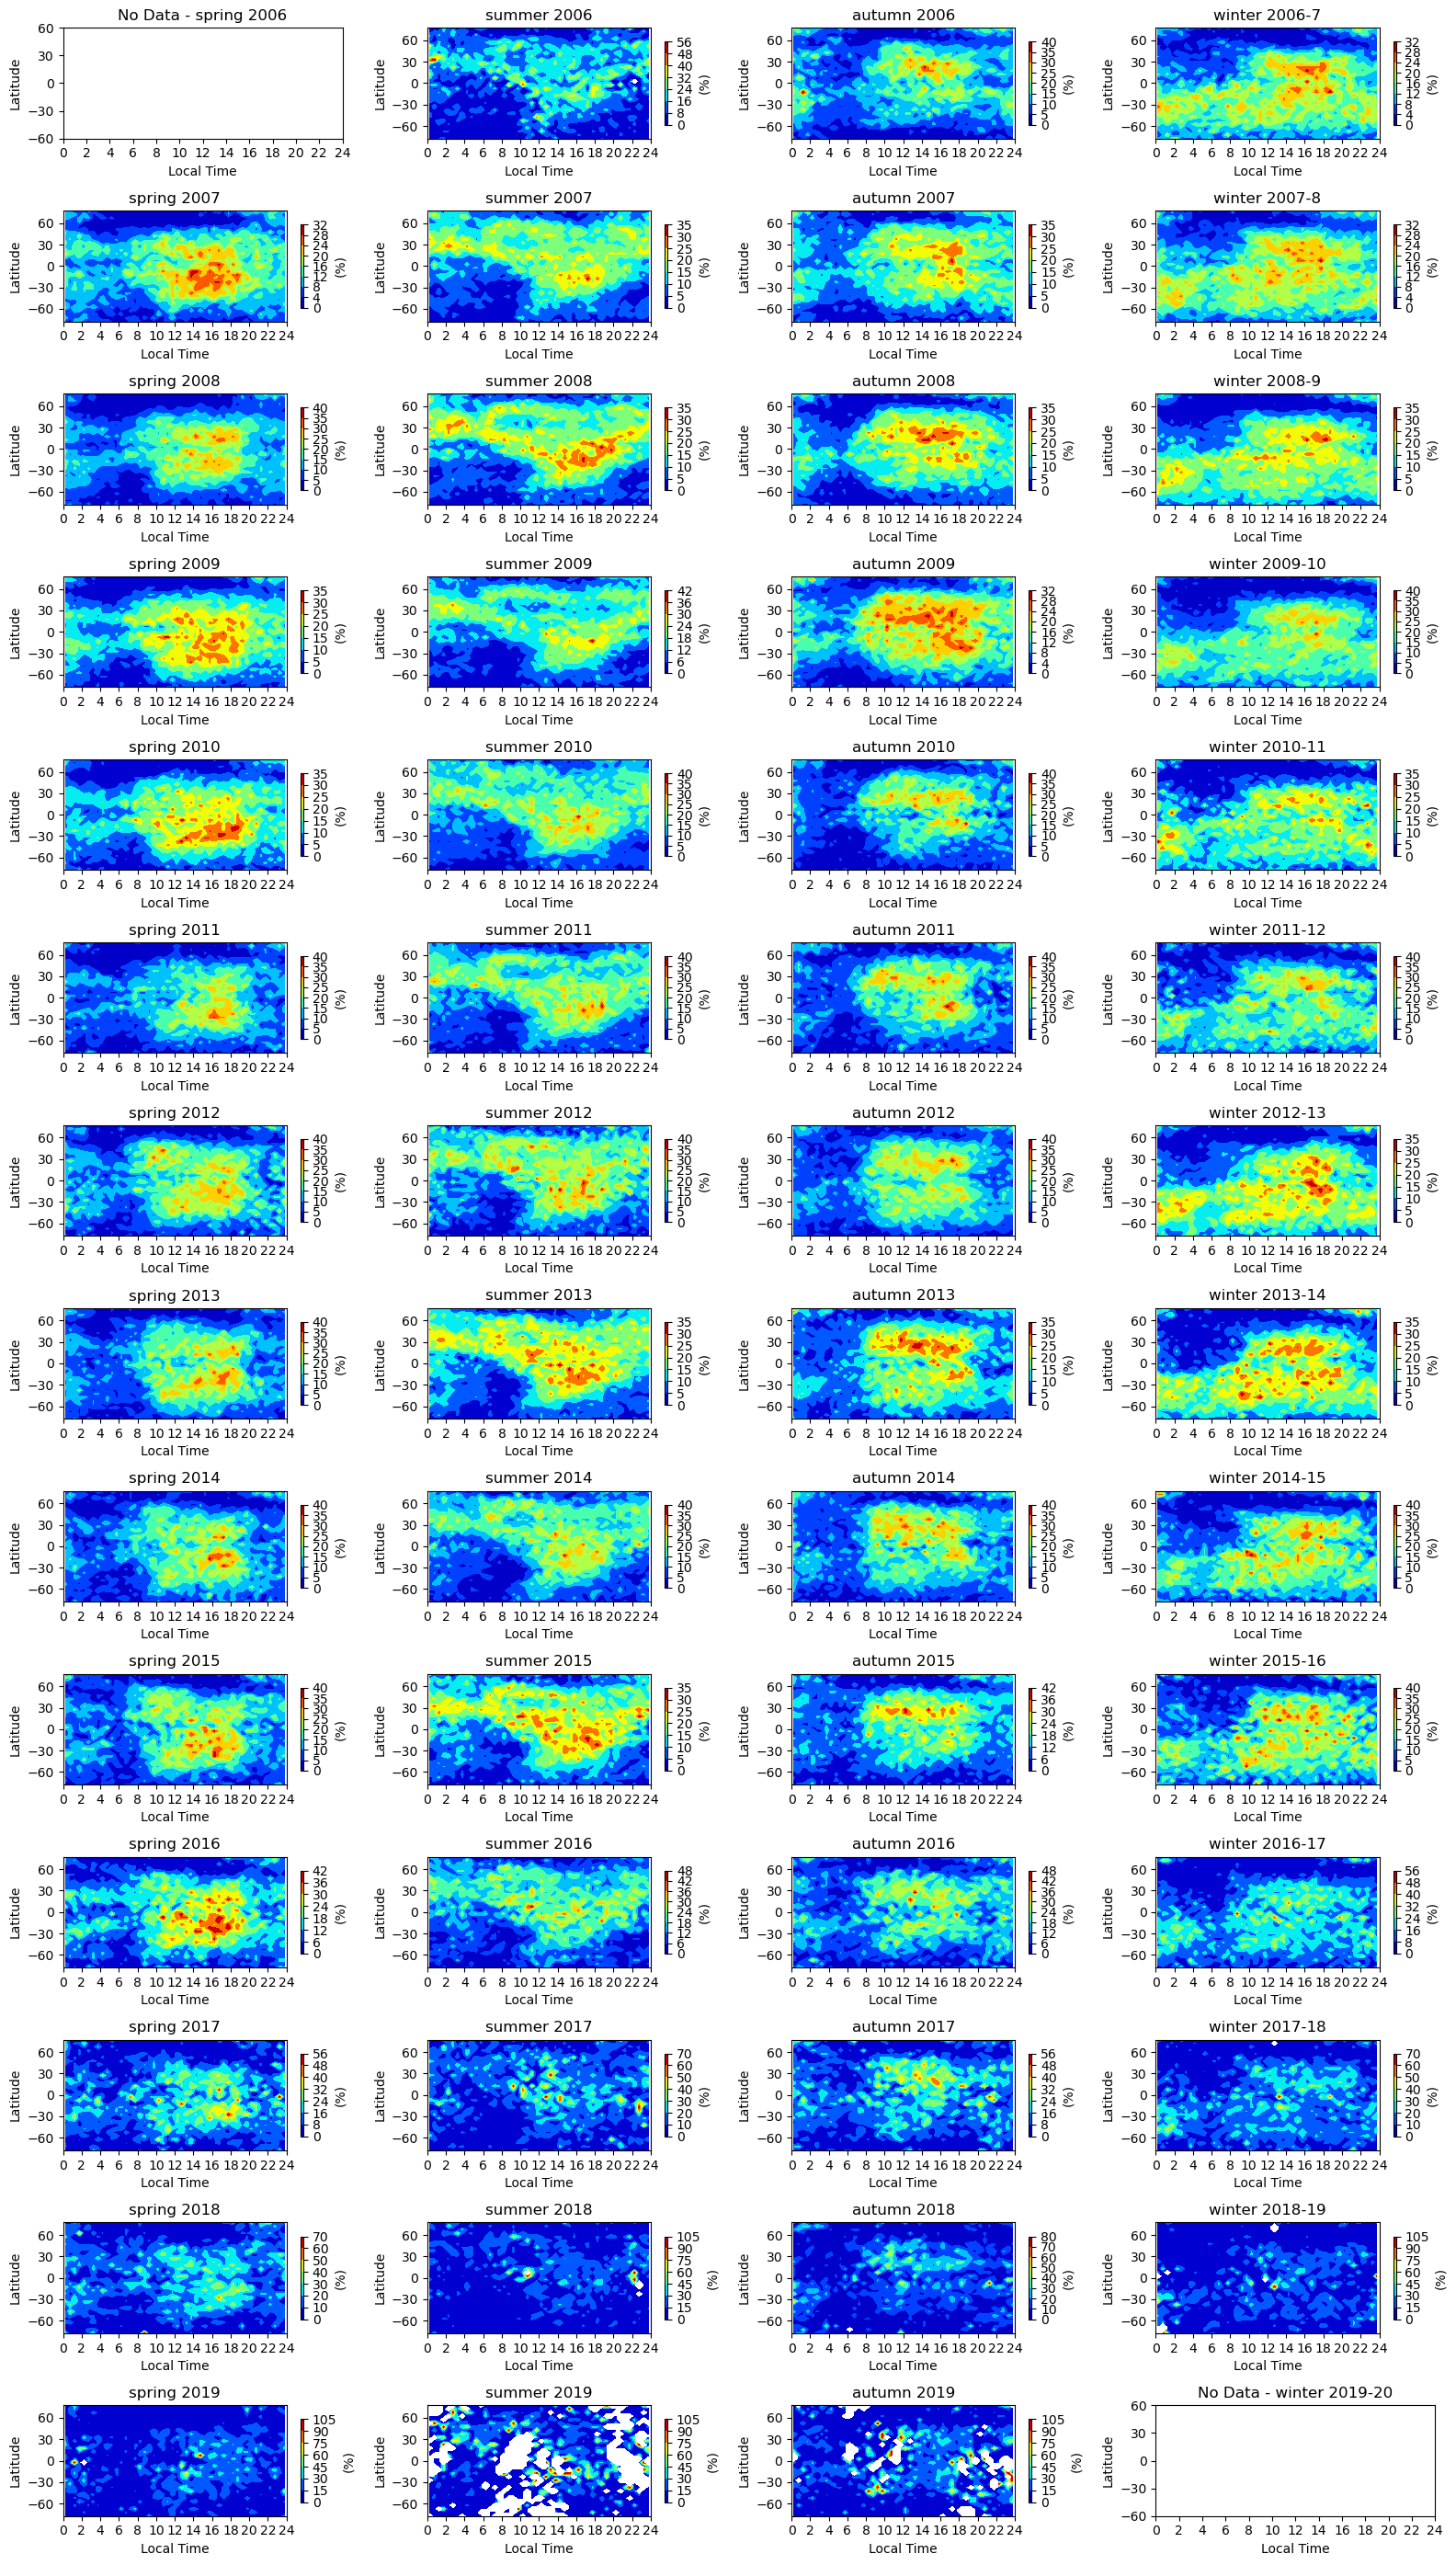

In [137]:
## PLOT ocfr_LT ##

# Define constants
vmin = 0
vmax = 100
nolevs = 11

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# Define seasons and years
seasons = ['spring', 'summer', 'autumn', 'winter']
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
winter_years = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

# Define the directory containing individual year files
data_directory = './Nc_Files/s4max/Daviddata/Individual_yrs/LT/'

# Create a subplot for each year
fig, axes = plt.subplots(len(years), len(seasons), figsize=(16, 28))

for i, year in enumerate(years):
    for j, season in enumerate(seasons):
        ax = axes[i, j]

        file_path = ''
        # Construct file path for the current season and year
        if season == 'winter':
            year = winter_years[i]
            year_start = int(year.split('-')[0])
            year_end = int(year.split('-')[1])
            file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_LT_5d.nc'
        else:
            file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_LT_5d.nc'

        # Check if the file exists
        if os.path.exists(file_path):
            # Load data for the current season and year
            output_ds = xr.open_dataset(file_path)
            latout = output_ds['latitude']
            ltout = output_ds['local_time']
            ocfr_out = output_ds['ocfr_LT']

            lat_indices = np.where((latout >= -80) & (latout <= 80))[0]
            latout_slice = latout[lat_indices]
            ocfr_out_slice = ocfr_out[lat_indices,:]
            
            # Plot occurrence frequency
            contour = ax.contourf(ltout, latout, ocfr_out, cmap='jet'
                                #, levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                                 )
            
            ax.set_title(f'{season} {year}')

            # Add colorbar
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
            cbar.set_label('(%)')

        else:
            # If the file doesn't exist, skip plotting and set title as 'No Data'
            ax.set_title(f'No Data - {season} {year}')

# Set common labels and ticks for all subplots
for ax in axes.flat:
    xticks = np.linspace(0, 24, 13)
    ax.set_xticks(xticks)
    ax.set_xlabel('Local Time')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()

figname = f'OcFr_latLT_years_seasons.png'
if fivedegbins == 1:
    figname = f'OcFr_latLT_years_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')


plt.show()


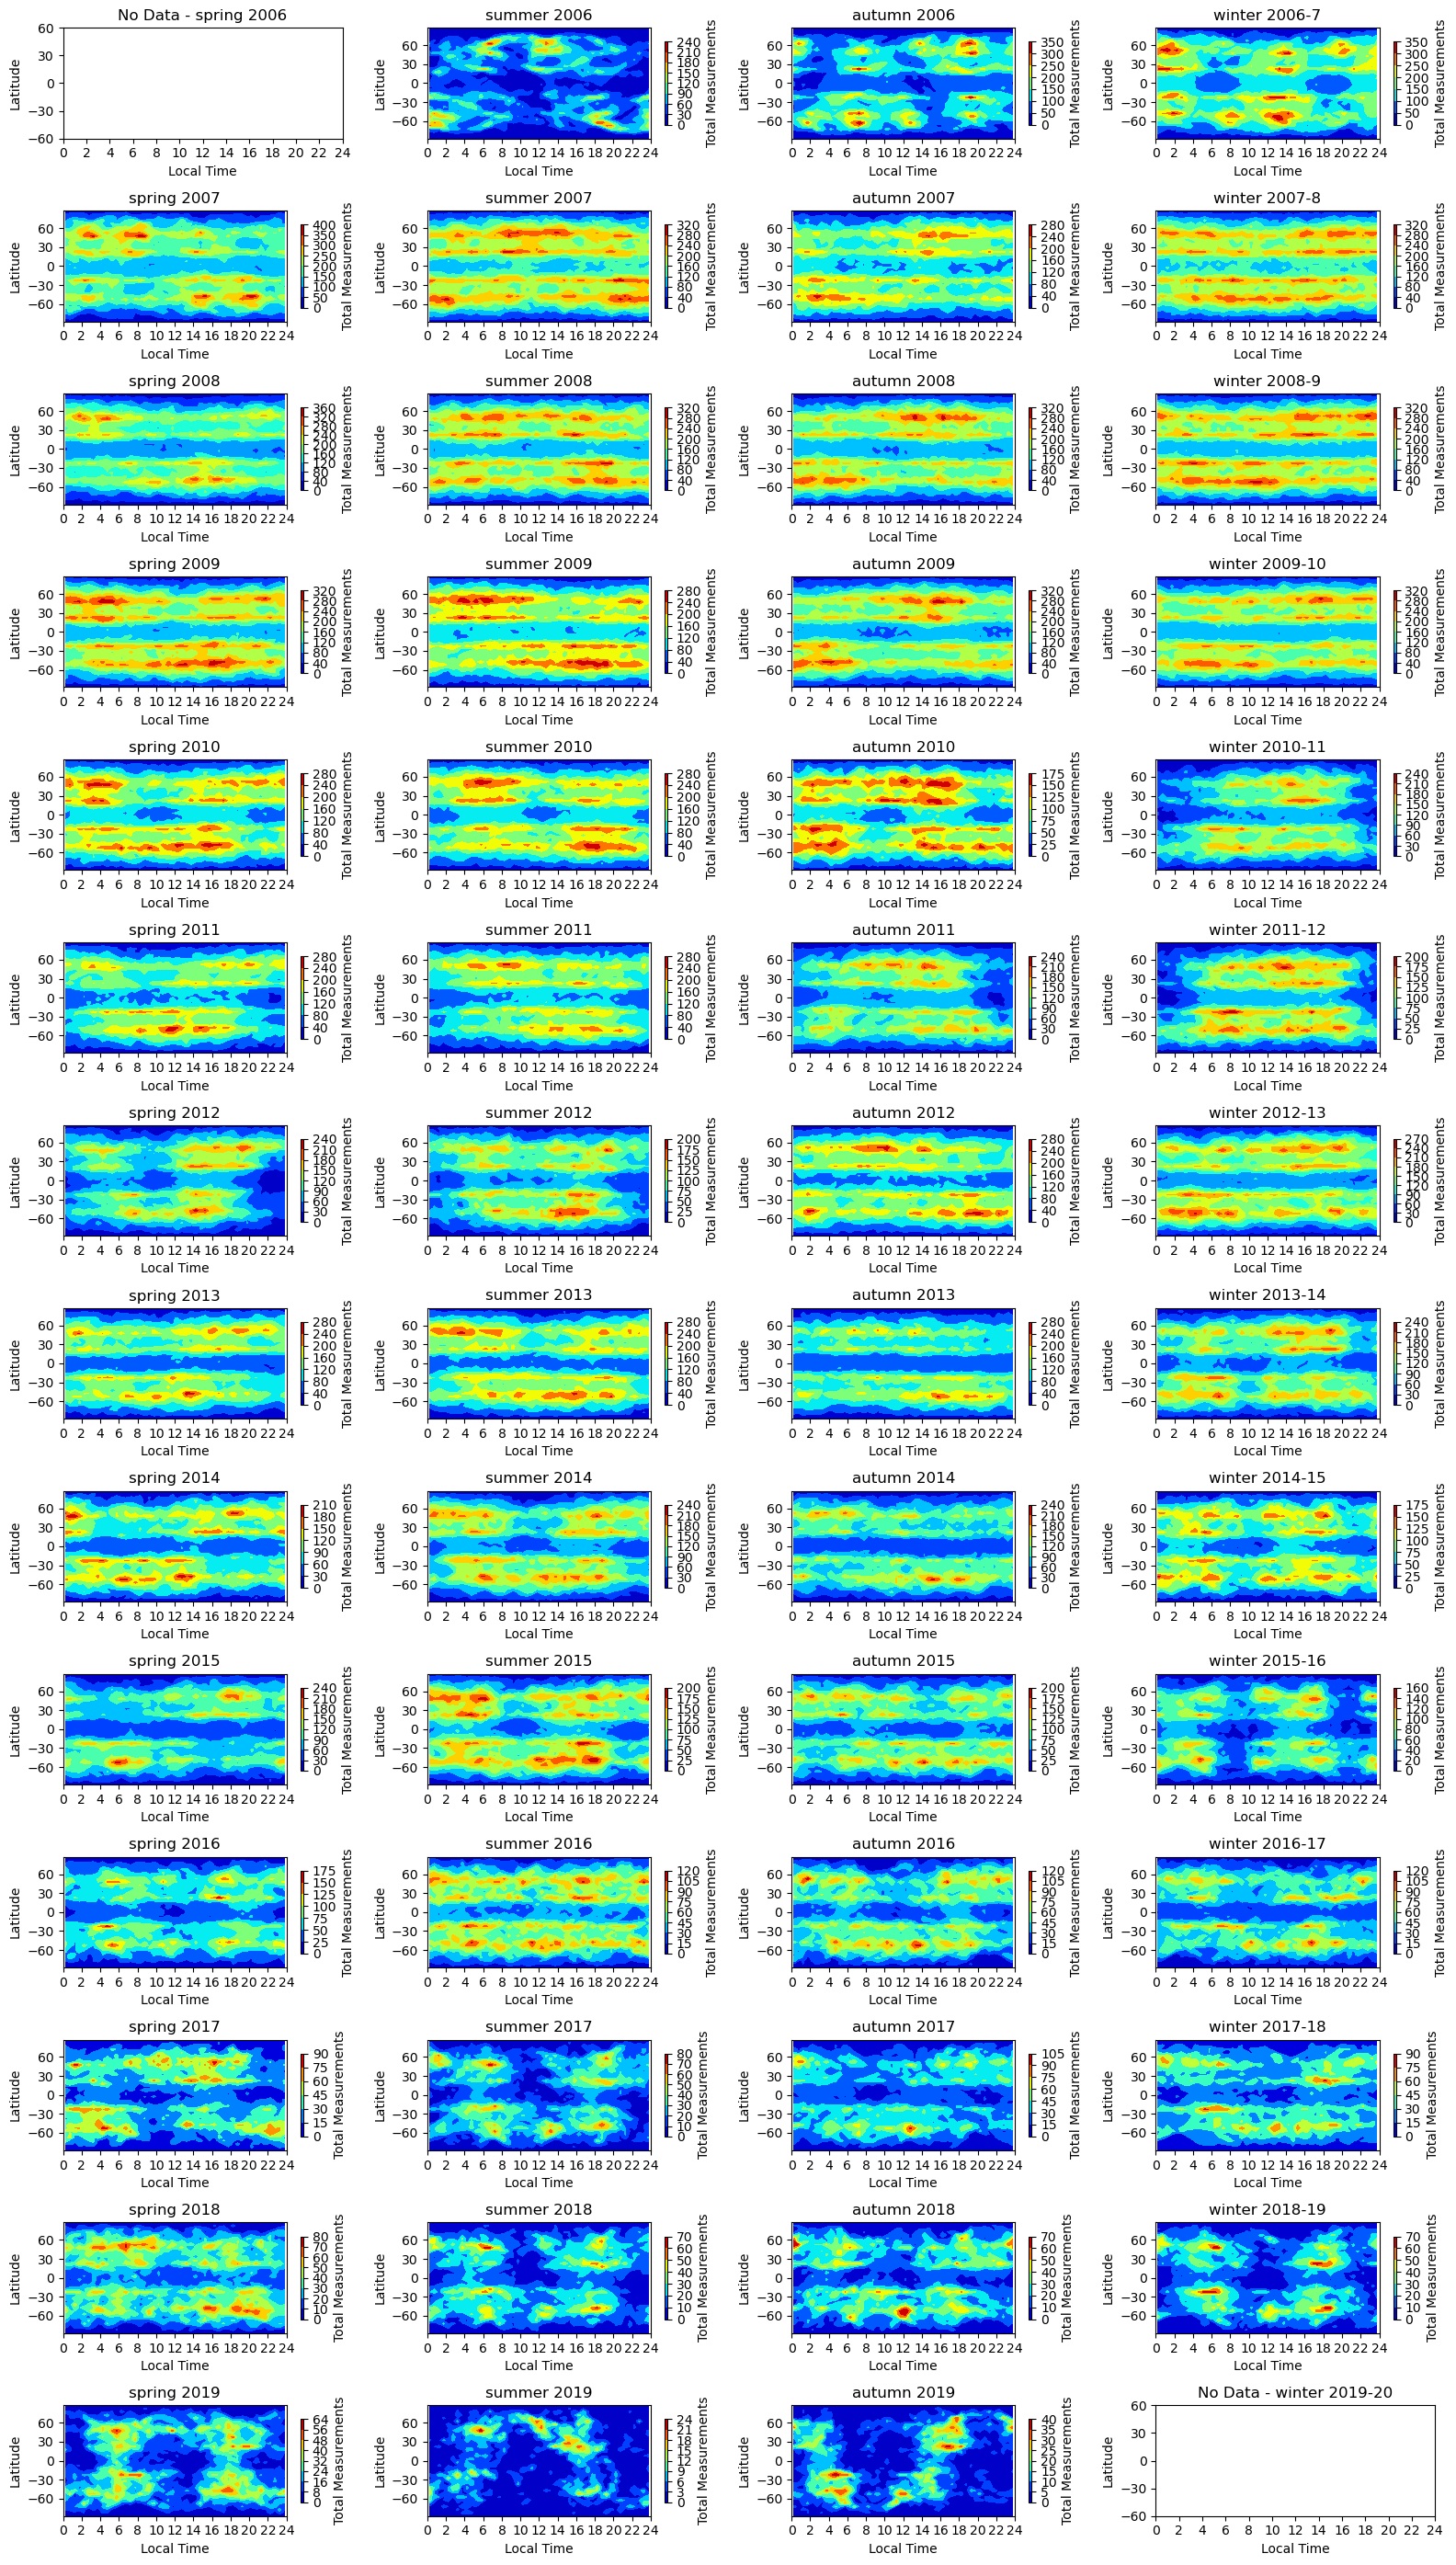

In [190]:
## PLOT nmeas_LT and freq_LT ##

# Define constants
vmin = 0
vmax = 100
nolevs = 11

mag_lat_contour_levels = [-80, -70, -60, -40, -20, 0, 20, 40, 60, 70, 80]

# Define seasons and years
seasons = ['spring', 'summer', 'autumn', 'winter']
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
winter_years = ['2006-7', '2007-8', '2008-9', '2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']

# Define the directory containing individual year files
data_directory = './Nc_Files/s4max/Daviddata/Individual_yrs/LT/'

# Create a subplot for each year
fig, axes = plt.subplots(len(years), len(seasons), figsize=(16, 28))

for i, year in enumerate(years):
    for j, season in enumerate(seasons):
        ax = axes[i, j]

        file_path = ''
        # Construct file path for the current season and year
        if season == 'winter':
            year = winter_years[i]
            year_start = int(year.split('-')[0])
            year_end = int(year.split('-')[1])
            file_path = f'{data_directory}Ocfr_Daviddata_{year_start}-{year_end}_{season}_LT_5d.nc'
        else:
            file_path = f'{data_directory}Ocfr_Daviddata_{year}_{season}_LT_5d.nc'

        # Check if the file exists
        if os.path.exists(file_path):
            # Load data for the current season and year
            output_ds = xr.open_dataset(file_path)
            latout = output_ds['latitude']
            ltout = output_ds['local_time']
            ocfr_out = output_ds['ocfr_LT']
            nmeas_LT_out = output_ds['nmeas_LT']
            freq_LT_out = output_ds['freq_LT']
            
#             lat_indices = np.where((latout >= -80) & (latout <= 80))[0]
#             latout_slice = latout[lat_indices]
#             ocfr_out_slice = ocfr_out[lat_indices,:]
            
            # Plot occurrence frequency
            contour = ax.contourf(ltout, latout, nmeas_LT_out, cmap='jet'
                                #, levels=np.linspace(vmin, vmax, nolevs), vmin=vmin, vmax=vmax
                                 )
            
            ax.set_title(f'{season} {year}')

            # Add colorbar
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05, aspect=30, shrink=0.75)
            cbar.set_label('Total Measurements')
            #cbar.set_label('# SpEs')

        else:
            # If the file doesn't exist, skip plotting and set title as 'No Data'
            ax.set_title(f'No Data - {season} {year}')

# Set common labels and ticks for all subplots
for ax in axes.flat:
    xticks = np.linspace(0, 24, 13)
    ax.set_xticks(xticks)
    ax.set_xlabel('Local Time')
    ax.set_yticks([-60, -30, 0, 30, 60])
    ax.set_ylabel('Latitude')

plt.tight_layout()


if fivedegbins == 1:
    figname = f'n_meas_latLT_years_seasons_5d.png'
    #figname = f'n_SpEs_latLT_years_seasons_5d.png'
    
plt.savefig('./Figures/Daviddata/' + str(figname), dpi=400, bbox_inches='tight')


plt.show()


# COSMIC Data Processing: Occ Freq (**ALT**-lat-**LT**), Seasons Separately

In [92]:
# Zavg_70150_bin_widths, Zavg_70150_bin_edges, Zavg_70150_bin_midpoints, Zavg_70150_num_bins

# Processing Normal Lat Lon coordinates
# Seasons separately
#======================================

# Define multiple sets of desired months
all_desired_months = [ [3, 4, 5] , [6, 7, 8], [9, 10, 11] , [12, 1, 2] ]
month_to_season = {
    (12, 1, 2): "winter",
    (3, 4, 5): "spring",
    (6, 7, 8): "summer",
    (9, 10, 11): "autumn" }

#freq_LT = np.zeros((lat_num_bins, LT_num_bins))

#ocfr_LT = np.zeros((lat_num_bins, LT_num_bins))    
 
ds_length = np.arange(fdatetimes.shape[0])


# Loop over each set of desired months
for desired_months in all_desired_months:
    print('Months ' + str(desired_months))

    season = month_to_season.get(tuple(desired_months), "unknown")
        
    print(season)
    
    averaging_period = 'Three-Month'
    
    nmeas_LT = np.zeros((Zavg_70150_num_bins, lat_num_bins, LT_num_bins))

    for i in tqdm(ds_length):
        current_lat = flat.values[i]
        #current_lon = flon.values[i]
        
        current_LT = local_times[i]
        time_part = current_LT.hour + current_LT.minute / 60 + current_LT.second / 3600
        
        current_s4max = fs4s.values[i]
        
        current_time = fdatetimes[i]
        current_month = current_time.month
        
        current_hmEs = fhmEs.values[i]
        
        if current_month in desired_months:      
            lat_bin_index = np.digitize(current_lat, lat_bin_edges) - 1
            #lon_bin_index = np.digitize(current_lon, lon_bin_edges) - 1
            LT_bin_index = np.digitize(time_part, LT_bin_edges) - 1
            alt_bin_index = np.digitize(current_hmEs, Zavg_70150_bin_edges) - 1
            
            if not np.isnan(current_s4max):
                nmeas_LT[alt_bin_index, lat_bin_index, LT_bin_index] += 1.

#             if not np.isnan(current_s4max):
#                 freq_LT[lat_bin_index, LT_bin_index] += 1.

#     ocfr_LT = (freq_LT / nmeas_LT) * 100.0

    ###########################################################################################################################
    # Save occurrence frequency to nc file
    Ocfr_ds = xr.Dataset(
        data_vars={
            "n_altlatLT": (['altitude','latitude', 'local_time'], nmeas_LT),
        },
        coords={
            "altitude": Zavg_70150_bin_midpoints,
            "latitude": lat_bin_midpoints,
            "local_time": LT_bin_midpoints,
        },
        attrs={
            'averaging_period': averaging_period,
        }
    )

    output_directory = "./Nc_Files/s4max/Daviddata/"
    output_file = f"{output_directory}n_Daviddata_{season}_altlatLT.nc"
    if fivedegbins == 1:
        output_file = f"{output_directory}n_Daviddata_{season}_altlatLT_5d.nc"
    Ocfr_ds.to_netcdf(output_file)

    ###########################################################################################################################


Months [3, 4, 5]
spring


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [23:52<00:00, 5344.51it/s]


Months [6, 7, 8]
summer


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [24:18<00:00, 5251.57it/s]


Months [9, 10, 11]
autumn


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [23:26<00:00, 5445.99it/s]


Months [12, 1, 2]
winter


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7657521/7657521 [23:49<00:00, 5357.81it/s]
